In [1]:

import os
import requests
import sys
import gzip

import datetime
import time




import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Button, HBox, VBox
import ipywidgets as widgets
import seaborn as sns
import pylab

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import ks_2samp


# Stat
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

In [3]:
reg = 4
file = os.path.join(folder_BD_propre, liste_file[reg])
df = pd.read_csv(file, low_memory=False)

In [4]:
df.loc[(df['Profil']=='RES11 (+ RES11WE)'), 'Plage de puissance souscrite'].unique()

array(['P0: Total <= 36 kVA', 'P3: ]6-9] kVA', 'P4: ]9-12] kVA',
       'P5: ]12-15] kVA', 'P6: ]15-18] kVA', 'P7: ]18-24] kVA',
       'P9: ]30-36] kVA'], dtype=object)

In [5]:
# Analsye des corrélations 

# Séparations das variables numériques et catégorielles
# Variables numériques
cl_num = df.select_dtypes(exclude=['object']).columns
# Variables catégorielles
cl_cat = df.select_dtypes(include=['object']).columns
# Dans cette partie j'effectue des encoadges  pour les varaibles catégorielles  : 
# et  j'effectue une première étude basée sur le tableau de contingencedes de ces varaibles catégorielles avec la cible
def analyse_variable_categorielle(df, variable_name, variable_cible):
    """
    """
    print()
    # Répartition des catégories
    print("Répartion des catégories pour la variable ", variable_name, end="\n\n")
    print(df[variable_name].value_counts(dropna = False, normalize=True), end="\n\n")
    # Tableau de contingence de la variable avec la variable Response
    print("Tableau de contingence entre la variable ", variable_name , " et la variable cible: ",
      end="\n\n")
    print(pd.crosstab(df[variable_name], variable_cible,
                      #df[variable_cible],
                      normalize='index'),
                      end="\n\n")
    """fig = plt.figure(figsize=(20,10))
    sns.countplot(x=variable_name, hue = variable_cible , data=df)
    plt.title(f'Répartition de {variable_name} \n', fontsize=20)
    plt.show()"""
    

for cl in cl_cat :
    print(cl, df[cl].unique())    
    analyse_variable_categorielle(df, cl, 'Total énergie soutirée (Wh)')


Région ['Grand-Est']

Répartion des catégories pour la variable  Région

Région
Grand-Est    1.0
Name: proportion, dtype: float64

Tableau de contingence entre la variable  Région  et la variable cible: 

col_0      Total énergie soutirée (Wh)
Région                                
Grand-Est                          1.0

Profil ['ENT3 (+ ENT4 + ENT5)' 'PRO1 (+ PRO1WE)' 'PRO2 (+ PRO2WE + PRO6)' 'PRO3'
 'PRO4' 'PRO5' 'RES1 (+ RES1WE)' 'RES11 (+ RES11WE)' 'RES2 (+ RES5)'
 'RES2WE' 'RES3' 'RES4']

Répartion des catégories pour la variable  Profil

Profil
PRO1 (+ PRO1WE)           0.149254
PRO2 (+ PRO2WE + PRO6)    0.134328
PRO5                      0.134328
RES2 (+ RES5)             0.134328
RES11 (+ RES11WE)         0.104478
RES3                      0.074627
RES2WE                    0.059701
RES4                      0.059701
PRO3                      0.044776
PRO4                      0.044776
RES1 (+ RES1WE)           0.044776
ENT3 (+ ENT4 + ENT5)      0.014925
Name: proportion, dtype

In [6]:
cl_num
cl_num = list(set(cl_num) - set(['year', 'month', 'day', 'h', 'mn', 's','Code région','AAAAMMJJHH']))
cl_num

['U_min',
 'Rayonnement solaire global (W/m2)',
 'FF_q25',
 'Courbe Moyenne n°1 + n°2 (Wh)',
 'FF_min',
 'T_kurtosis',
 'Nb points soutirage',
 'FF_moyenne',
 'Semaine max du mois (0/1)',
 'T_skew',
 'T_q75',
 'T_q25',
 'Courbe Moyenne n°2 (Wh)',
 'U_q75',
 'Courbe Moyenne n°1 (Wh)',
 'T_q50',
 'U_STD',
 'Jour max du mois (0/1)',
 'Total énergie soutirée (Wh)',
 'U_moyenne',
 'FF_q50',
 'T_max',
 'T_moyenne',
 'U_max',
 'T_min',
 'FF_STD',
 'T_STD',
 'U_q50',
 'FF_q75',
 'FF_max',
 'U_q25']

In [7]:
 # Différenciation du premier ordre et du second ordre
cl_num = ['T_moyenne', 'FF_moyenne', 'U_moyenne', 'Rayonnement solaire global (W/m2)', 'Total énergie soutirée (Wh)'] 
#df[['T_moyenne', 'FF_moyenne', 'U_moyenne', 'Rayonnement solaire global (W/m2)']] = 1/df[['T_moyenne', 'FF_moyenne', 'U_moyenne', 'Rayonnement solaire global (W/m2)']]  
#df[cl_num] = np.log(df[cl_num])
df_diff_1 = df[cl_num].diff().dropna()
df_diff_2 = df[cl_num].diff().diff().dropna()
corr_pearson = df[cl_num].corr(method='pearson')
corr_pearson_1 = df_diff_1.corr(method='pearson')  # Corrélation linéaire
corr_pearson_2= df_diff_2.corr(method='pearson') 

#corr_spearman = df_T[L].corr(method='spearman')  # Corrélation monotone
display(corr_pearson) 
#print("Corrélation Pearson diff 1")
display(corr_pearson_1)
    #print("Corrélation Pearson diff 2")
display(corr_pearson_2)

T_moyenne  FF_moyenne  U_moyenne  \
T_moyenne                           1.000000   -0.065882  -0.596457   
FF_moyenne                         -0.065882    1.000000  -0.092395   
U_moyenne                          -0.596457   -0.092395   1.000000   
Rayonnement solaire global (W/m2)   0.596903   -0.003964  -0.744947   
Total énergie soutirée (Wh)        -0.102935    0.031612   0.035876   

                                   Rayonnement solaire global (W/m2)  \
T_moyenne                                                   0.596903   
FF_moyenne                                                 -0.003964   
U_moyenne                                                  -0.744947   
Rayonnement solaire global (W/m2)                           1.000000   
Total énergie soutirée (Wh)                                -0.032701   

                                   Total énergie soutirée (Wh)  
T_moyenne                                            -0.102935  
FF_moyenne                                            0.031612  
U_moyenne                                             0.035876  
Rayonnement solaire global (W/m2)                    -0.032701  
Total énergie soutirée (Wh)                           1.000000

T_moyenne  FF_moyenne  U_moyenne  \
T_moyenne                           1.000000    0.518074  -0.923005   
FF_moyenne                          0.518074    1.000000  -0.514525   
U_moyenne                          -0.923005   -0.514525   1.000000   
Rayonnement solaire global (W/m2)   0.460124    0.214613  -0.487834   
Total énergie soutirée (Wh)        -0.018557   -0.024423   0.021430   

                                   Rayonnement solaire global (W/m2)  \
T_moyenne                                                   0.460124   
FF_moyenne                                                  0.214613   
U_moyenne                                                  -0.487834   
Rayonnement solaire global (W/m2)                           1.000000   
Total énergie soutirée (Wh)                                -0.013847   

                                   Total énergie soutirée (Wh)  
T_moyenne                                            -0.018557  
FF_moyenne                                           -0.024423  
U_moyenne                                             0.021430  
Rayonnement solaire global (W/m2)                    -0.013847  
Total énergie soutirée (Wh)                           1.000000

T_moyenne  FF_moyenne  U_moyenne  \
T_moyenne                           1.000000    0.518074  -0.923005   
FF_moyenne                          0.518074    1.000000  -0.514525   
U_moyenne                          -0.923005   -0.514525   1.000000   
Rayonnement solaire global (W/m2)   0.460124    0.214613  -0.487834   
Total énergie soutirée (Wh)        -0.018893   -0.025342   0.022011   

                                   Rayonnement solaire global (W/m2)  \
T_moyenne                                                   0.460124   
FF_moyenne                                                  0.214613   
U_moyenne                                                  -0.487834   
Rayonnement solaire global (W/m2)                           1.000000   
Total énergie soutirée (Wh)                                -0.012954   

                                   Total énergie soutirée (Wh)  
T_moyenne                                            -0.018893  
FF_moyenne                                           -0.025342  
U_moyenne                                             0.022011  
Rayonnement solaire global (W/m2)                    -0.012954  
Total énergie soutirée (Wh)                           1.000000

D:\Temp\ipykernel_14548\1657781038.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total énergie soutirée (Wh)'] = np.log(data['Total énergie soutirée (Wh)'])


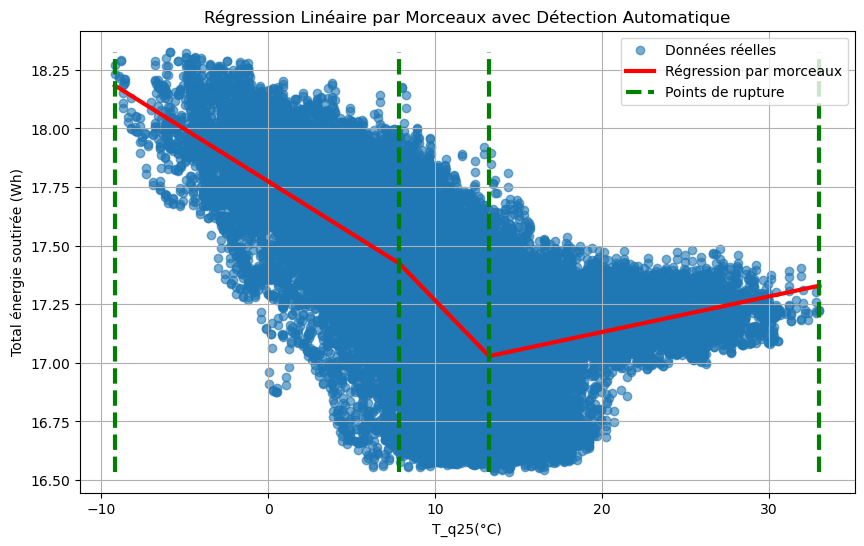

Points de rupture détectés : [-9.175       7.86030638 13.22500001 33.        ]


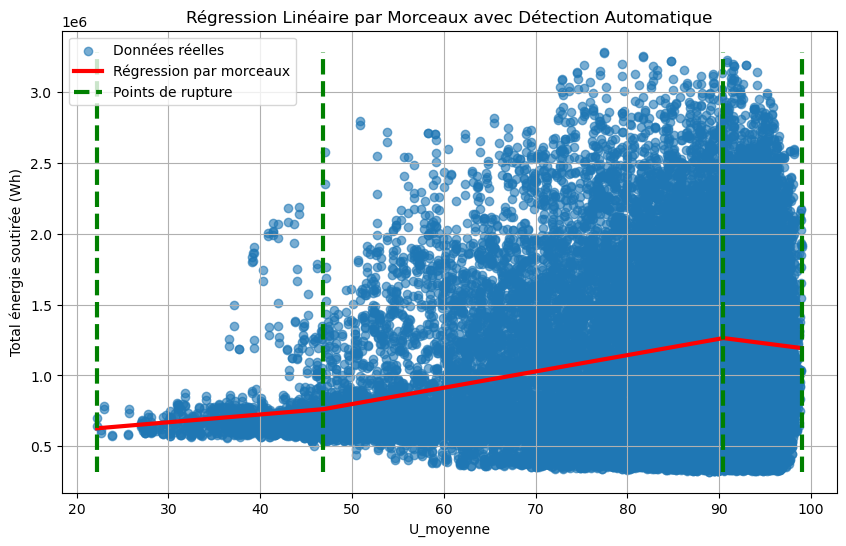

Points de rupture détectés : [22.24615385 46.81532135 90.44486156 98.96923077]


In [8]:
# les données présentent des comportements distincts dans différentes plages de valeurs et ceci pour chaque profile et chaque puissance souscrite
# Recherche de spécification linéaire de la témpérature : 
# i.e. une régression linéaire par morceaux (ou piecewise linear regression) qui ajuste plusieurs 
# segments linéaires sur différentes portions des données. 

col = 'T_q25'
import pwlf 
data = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P3: ]6-9] kVA')]
# Model de specification linéaire 
#data[col] = data[col].apply(lambda x : 1/(x + 20 ))
data['Total énergie soutirée (Wh)'] = np.log(data['Total énergie soutirée (Wh)'])

data = data.dropna()
model = pwlf.PiecewiseLinFit(data[col], data['Total énergie soutirée (Wh)'])

# Détection automatique des points de rupture
# Par exemple : 3 segments (ce paramètre peut être ajusté)
num_segments = 3
breaks = model.fit(num_segments)

# Prédiction des valeurs ajustées

T_hat = np.linspace(min(data[col]), max(data[col]), 1000)
Consommation_hat = model.predict(T_hat)




plt.figure(figsize=(10, 6))
plt.scatter(data[col], data['Total énergie soutirée (Wh)'], label='Données réelles', alpha=0.6)
plt.plot(T_hat, Consommation_hat, color='red', label='Régression par morceaux', linewidth=3)
plt.vlines(breaks, ymin=min(data['Total énergie soutirée (Wh)']), ymax=max(data['Total énergie soutirée (Wh)']), colors='green', linestyles='dashed',linewidth=3, label='Points de rupture')
plt.title('Régression Linéaire par Morceaux avec Détection Automatique')
plt.xlabel(col + '(°C)')
plt.ylabel('Total énergie soutirée (Wh)')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des points de rupture
print(f"Points de rupture détectés : {breaks}")


col2 = 'U_moyenne'

data[col2] = np.log(data[col2])

# Autre données 
data = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P7: ]18-24] kVA')]
# Model de specification linéaire 
model = pwlf.PiecewiseLinFit(data[col2], data['Total énergie soutirée (Wh)'])

# Détection automatique des points de rupture
# Par exemple : 3 segments (ce paramètre peut être ajusté)
num_segments = 3
breaks = model.fit(num_segments)

# Prédiction des valeurs ajustées

U_hat = np.linspace(min(data[col2]), max(data[col2]), 1000)
Consommation_hat = model.predict(U_hat)




plt.figure(figsize=(10, 6))
plt.scatter(data[col2], data['Total énergie soutirée (Wh)'], label='Données réelles', alpha=0.6)
plt.plot(U_hat, Consommation_hat, color='red', label='Régression par morceaux', linewidth=3)
plt.vlines(breaks, ymin=min(data['Total énergie soutirée (Wh)']), ymax=max(data['Total énergie soutirée (Wh)']), colors='green', linestyles='dashed',linewidth=3, label='Points de rupture')
plt.title('Régression Linéaire par Morceaux avec Détection Automatique')
plt.xlabel(col2)
plt.ylabel('Total énergie soutirée (Wh)')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des points de rupture
print(f"Points de rupture détectés : {breaks}")


In [9]:
#Analyse de la consommation en tant que série temporelle 
sub_df = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P3: ]6-9] kVA')]
valeurs = sub_df['Total énergie soutirée (Wh)']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d = {'date': date, 'consommation': valeurs}


serie = pd.DataFrame(d)
serie.set_index('date', inplace=True)
start_time = serie.index.min()
serie.index = ((serie.index - start_time).total_seconds() / 1800).astype(int)



#Analyse de la température moyenne en tant que série temporelle 
valeurs_T = sub_df['T_moyenne']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d_T = {'date': date, 'T_moyenne': valeurs_T}


serie_T = pd.DataFrame(d_T)
serie_T.set_index('date', inplace=True)
start_time = serie_T.index.min()
serie_T.index = ((serie_T.index - start_time).total_seconds() / 1800).astype(int)


D:\Temp\ipykernel_14548\922245561.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
D:\Temp\ipykernel_14548\922245561.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))


In [10]:
# Etude de stationnarité

from statsmodels.tsa.stattools import adfuller, kpss  

print("Test pour la série originelle")
adf_test = adfuller(serie)

# 📌 Récupérer les résultats
adf_statistic, p_value, used_lags, n_obs, critical_values, _ = adf_test

# 📌 Afficher les résultats
print("📊 Test de Dickey-Fuller Augmenté (ADF) :")
print(f"Statistique ADF : {adf_statistic}")
print(f"P-value : {p_value}")
print(f"Nombre de lags utilisés : {used_lags}")
print(f"Nombre d'observations : {n_obs}")
print(f"Seuils critiques : {critical_values}")

# 📌 Interprétation
if p_value < 0.05:
    print("✅ La série est stationnaire (on rejette H0)")
else:
    print("❌ La série n'est PAS stationnaire (on ne rejette pas H0)")




# Test pour la série différenciée 
print('-------------------------------------')

ordre_diff = 48
print("Test pour la série différenciée d'ordre",ordre_diff )
adf_test = adfuller(serie.diff(1).dropna())

# 📌 Récupérer les résultats
adf_statistic, p_value, used_lags, n_obs, critical_values, _ = adf_test

# 📌 Afficher les résultats
print("📊 Test de Dickey-Fuller Augmenté (ADF) :")
print(f"Statistique ADF : {adf_statistic}")
print(f"P-value : {p_value}")
print(f"Nombre de lags utilisés : {used_lags}")
print(f"Nombre d'observations : {n_obs}")
print(f"Seuils critiques : {critical_values}")

# 📌 Interprétation
if p_value < 0.05:
    print("✅ La série est stationnaire (on rejette H0)")
else:
    print("❌ La série n'est PAS stationnaire (on ne rejette pas H0)")

Test pour la série originelle
📊 Test de Dickey-Fuller Augmenté (ADF) :
Statistique ADF : -2.79652968915778
P-value : 0.058771189684118715
Nombre de lags utilisés : 51
Nombre d'observations : 32106
Seuils critiques : {'1%': -3.4305536947270814, '5%': -2.8616300277803064, '10%': -2.566817919002412}
❌ La série n'est PAS stationnaire (on ne rejette pas H0)
-------------------------------------
Test pour la série différenciée d'ordre 48
📊 Test de Dickey-Fuller Augmenté (ADF) :
Statistique ADF : -24.788383086551686
P-value : 0.0
Nombre de lags utilisés : 50
Nombre d'observations : 32106
Seuils critiques : {'1%': -3.4305536947270814, '5%': -2.8616300277803064, '10%': -2.566817919002412}
✅ La série est stationnaire (on rejette H0)


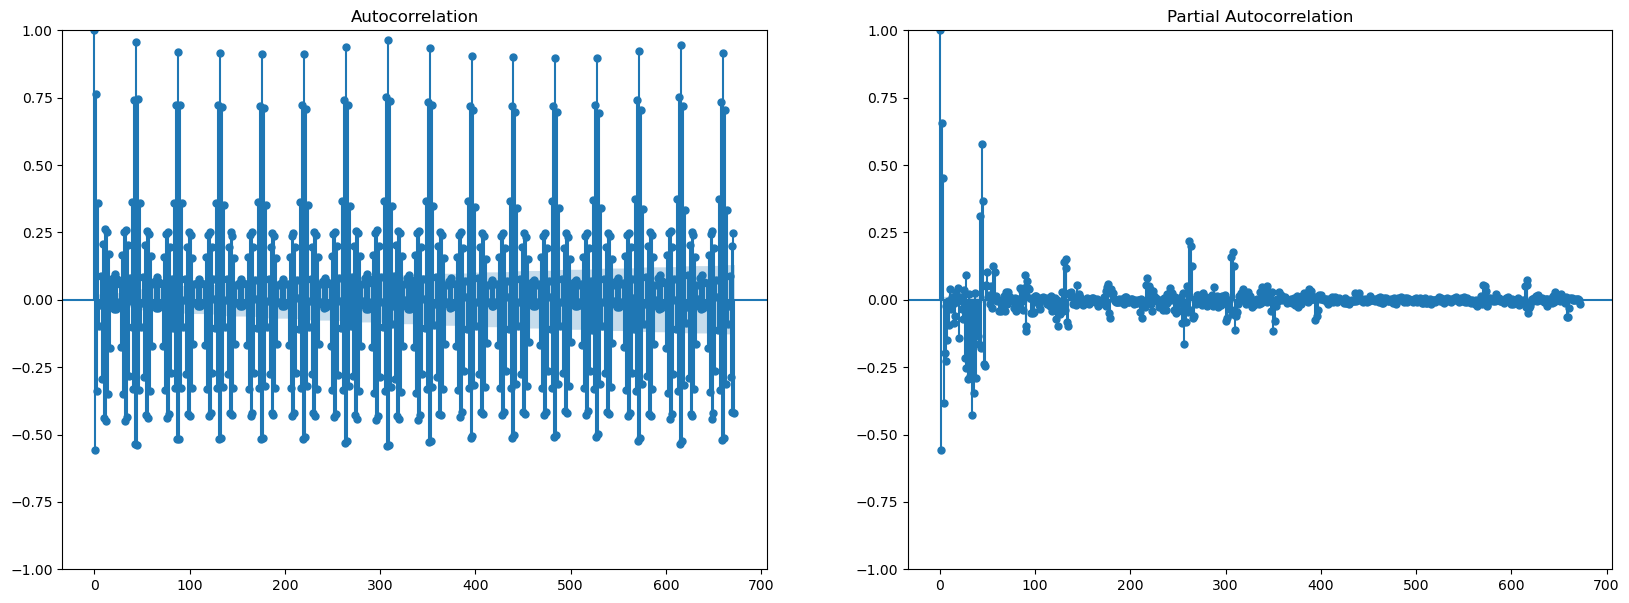

In [11]:
# Etude de l'autocorrélation et autocorrélation partielle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
serie_log =  np.log(serie) # serie
serie_log_1 = serie_log.diff().dropna()
serie_log_2 = serie_log_1.diff().dropna()
serie_log_3 = serie_log_2.diff().dropna()


decomposition = seasonal_decompose(serie_log_1, period=48,  extrapolate_trend='freq')
serie_2 = decomposition.trend
#serie_3 = serie_2.diff(periods=7*48).dropna()
#serie_4 = serie_3.diff(periods=365*48).dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(serie_log_1, lags = 14*48, ax=ax1)
plot_pacf(serie_log_1, lags = 14*48, ax=ax2)
plt.show()

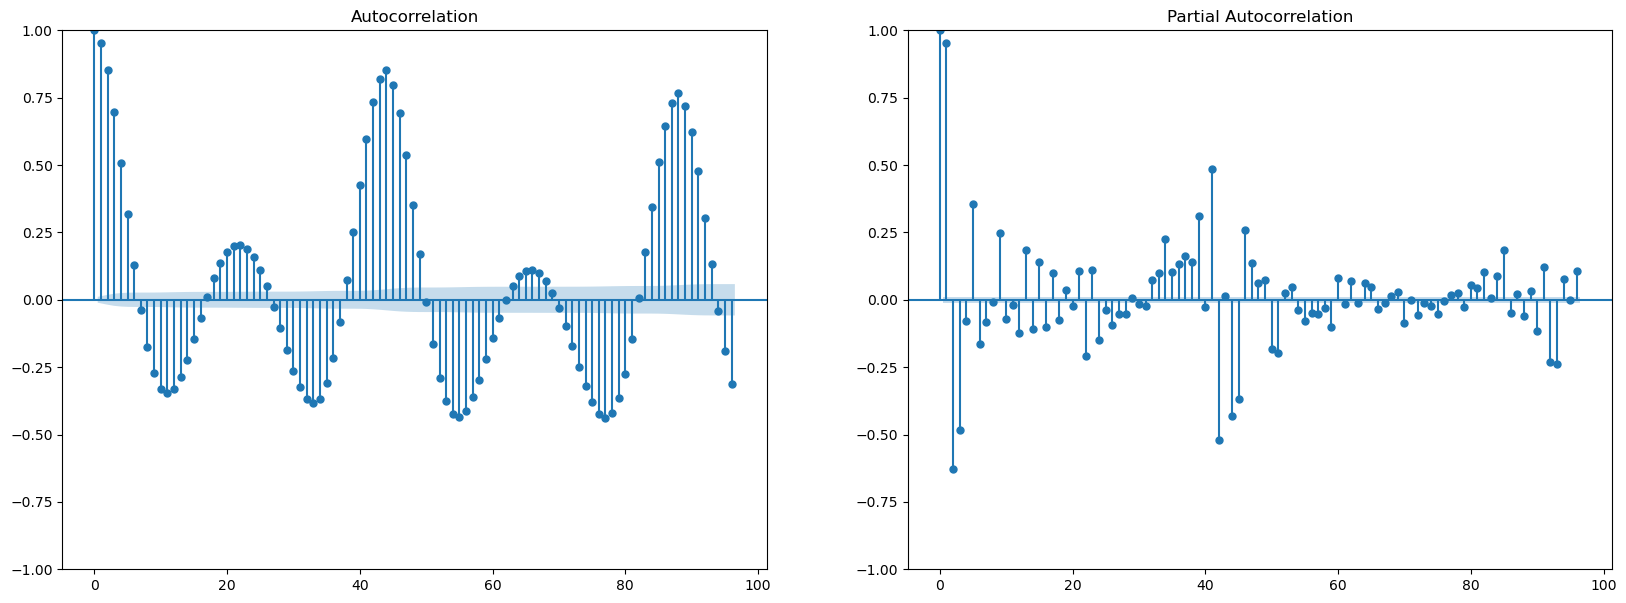

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(serie_2, lags = 2*48, ax=ax1)
plot_pacf(serie_2, lags = 2*48, ax=ax2)
plt.show()

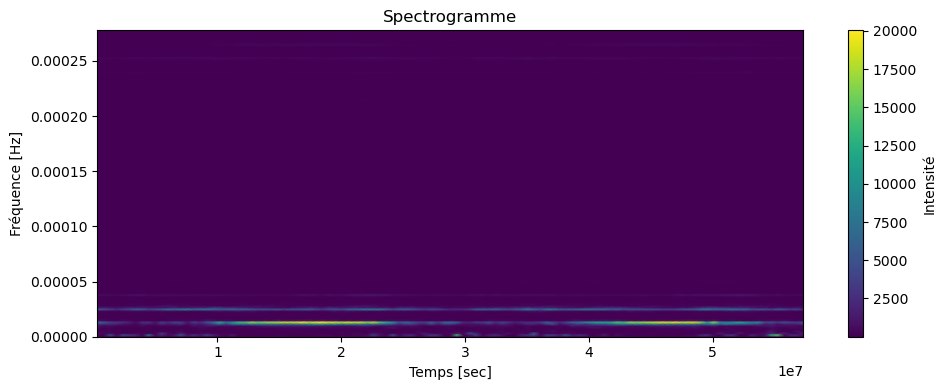

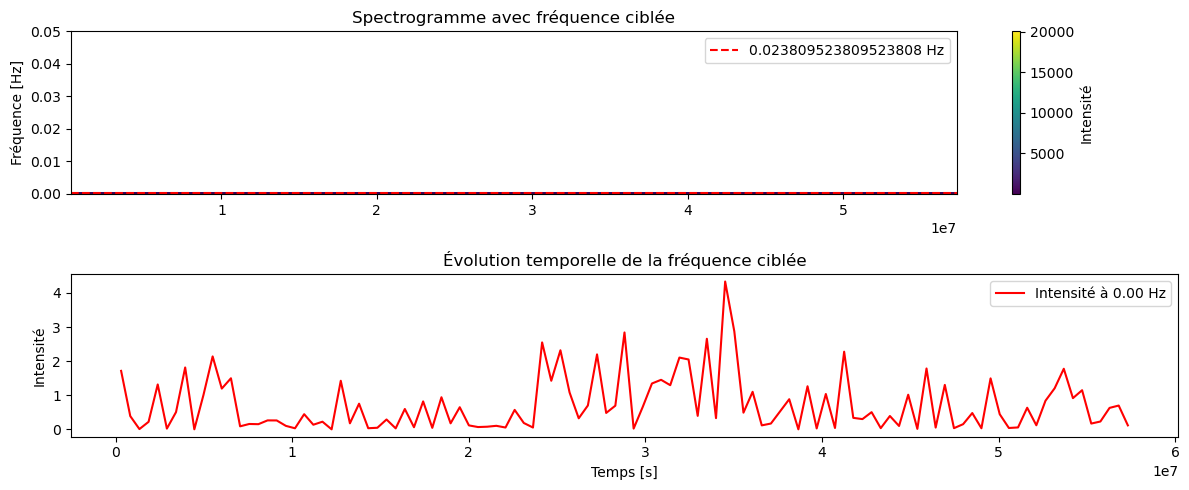

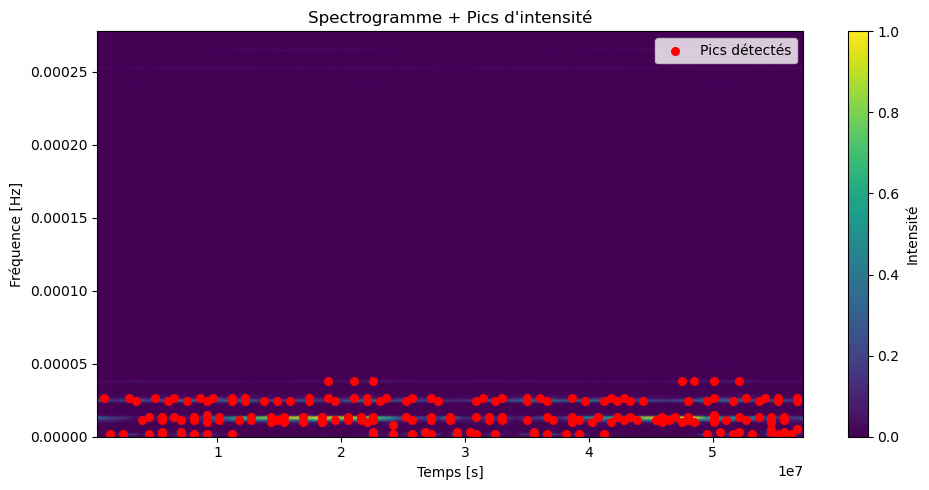

##############################################
Analyse spectrale de la température moyenne


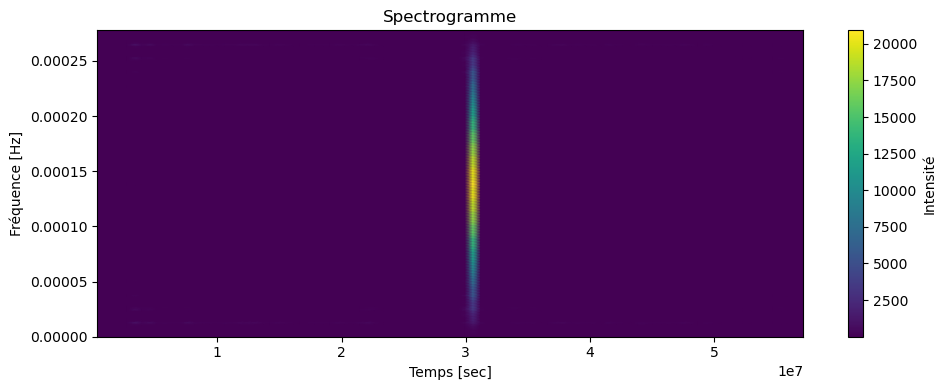

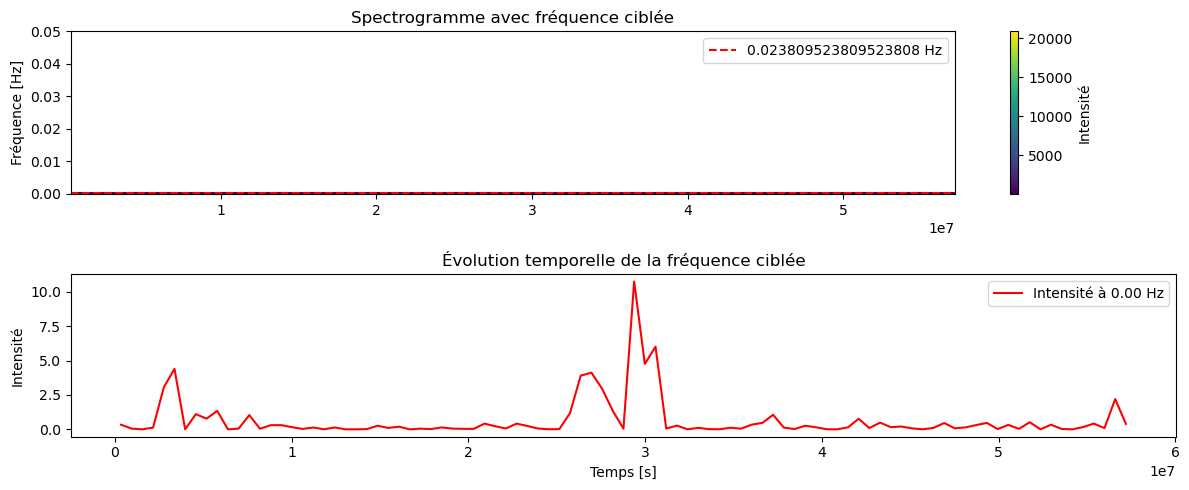

In [13]:
# Analyse spectrales
from scipy.signal import spectrogram
from scipy.signal import spectrogram, find_peaks
#serie_sp = (serie.values.reshape(1,len(serie_log))[0])

#serie_sp = sub_df['Total énergie soutirée (Wh)']
def plot_spectrogramme(f, t_spec, Sxx):
    # Affichage
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
    plt.ylabel('Fréquence [Hz]')
    plt.xlabel('Temps [sec]')
    #plt.ylim([0, 0.1])
    plt.title('Spectrogramme')
    plt.colorbar(label='Intensité')
    plt.tight_layout()
    plt.show()



def marquage_raie_spectre( f, t_spec, Sxx, target_freq):
    freq_idx = np.argmin(np.abs(f - target_freq))
    #  Extraire son intensité dans le temps
    intensity_at_freq = Sxx[freq_idx, :]
    # Afficher le spectrogramme + la courbe à 5 Hz
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
    plt.axhline(f[freq_idx], color='r', linestyle='--', label=f'{target_freq} Hz')
    plt.colorbar(label='Intensité')
    plt.ylabel('Fréquence [Hz]')
    plt.ylim([0, 0.05])
    plt.title('Spectrogramme avec fréquence ciblée')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(t_spec, intensity_at_freq, label=f"Intensité à {f[freq_idx]:.2f} Hz", color='r')
    plt.xlabel('Temps [s]')
    plt.ylabel('Intensité')
   
    plt.title('Évolution temporelle de la fréquence ciblée')
    plt.legend()

    plt.tight_layout()
    plt.show()





def identification_peak(f, t_spec, Sxx,threshold ):
    peak_coords = []
    for freq_idx, power in enumerate(Sxx):
        peaks, properties = find_peaks(power, height=threshold)
        for p in peaks:
                peak_coords.append((t_spec[p], f[freq_idx], power[p]))
    # Résultat sous forme de tableau
    peak_coords = np.array(peak_coords)
    # Affichage du spectrogramme + pics
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
    plt.scatter(peak_coords[:, 0], peak_coords[:, 1], c='red', s=30, label='Pics détectés')
    plt.xlabel('Temps [s]')
    plt.ylabel('Fréquence [Hz]')
    plt.colorbar(label='Intensité')
    plt.title('Spectrogramme + Pics d\'intensité')
    #plt.ylim([0, 0.05])
    plt.legend()
    plt.tight_layout()
    plt.show()
    return peak_coords







# Analyse spectrale 
serie_sp =np.log(serie.dropna()['consommation'])

f, t_spec, Sxx = spectrogram(serie_sp,  nperseg = 7*48, noverlap = 48, fs=1/1800)

plot_spectrogramme(f, t_spec, Sxx)

marquage_raie_spectre( f, t_spec, Sxx, target_freq = 1/42)
picks  = identification_peak(f, t_spec, Sxx,threshold = 0.1e4)


print("##############################################")
print("Analyse spectrale de la température moyenne")
serie_T_log = np.log(serie_T + np.abs((1+1e-10)*np.min(serie_T)))
serie_T_sp = serie_T_log.diff().dropna()['T_moyenne']
f_T, t_spec_T, Sxx_T = spectrogram(serie_T_sp,nperseg=8*48,noverlap=48 ,  fs=1/1800,window=('tukey') )
plot_spectrogramme(f_T, t_spec_T, Sxx_T)
marquage_raie_spectre( f_T, t_spec_T, Sxx_T, target_freq = 1/42)
#identification_peak(f_T, t_spec_T, Sxx_T,threshold = 0.5)


In [14]:
spectrum_mean = np.mean(Sxx, axis=1)

# Fréquences avec pics
from scipy.signal import find_peaks

peaks, _ = find_peaks(spectrum_mean, height=np.max(spectrum_mean)*0.05)  # seuil à ajuster
frequencies_raies = f[peaks]
print("Fréquences des raies spectrales (j) :", 1/(1800*48*frequencies_raies))

Fréquences des raies spectrales (j) : [7.         0.875      0.46666667 0.30434783]


D:\Temp\ipykernel_14548\251071085.py:5: RuntimeWarning: divide by zero encountered in divide
  fSxx = Sxx/mat_f


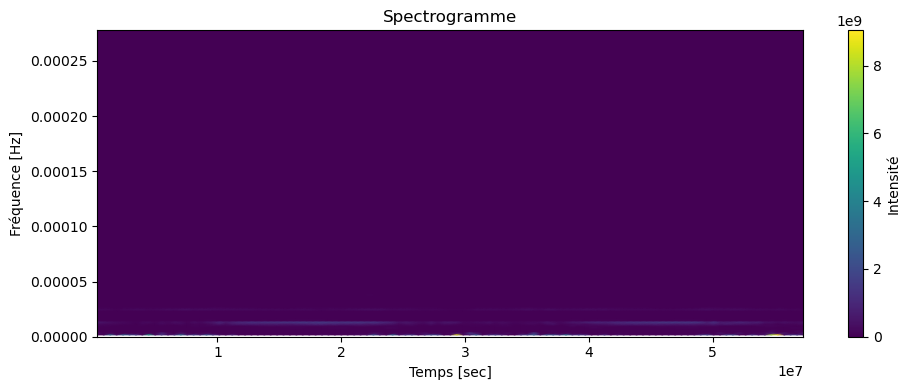

In [15]:
colonne_ones = np.ones((1,Sxx.shape[1]))
ligne_f = np.zeros((f.shape[0],1))
ligne_f[:,0] = f[0:]
mat_f = np.dot(ligne_f, colonne_ones)
fSxx = Sxx/mat_f

plot_spectrogramme(f, t_spec, fSxx)

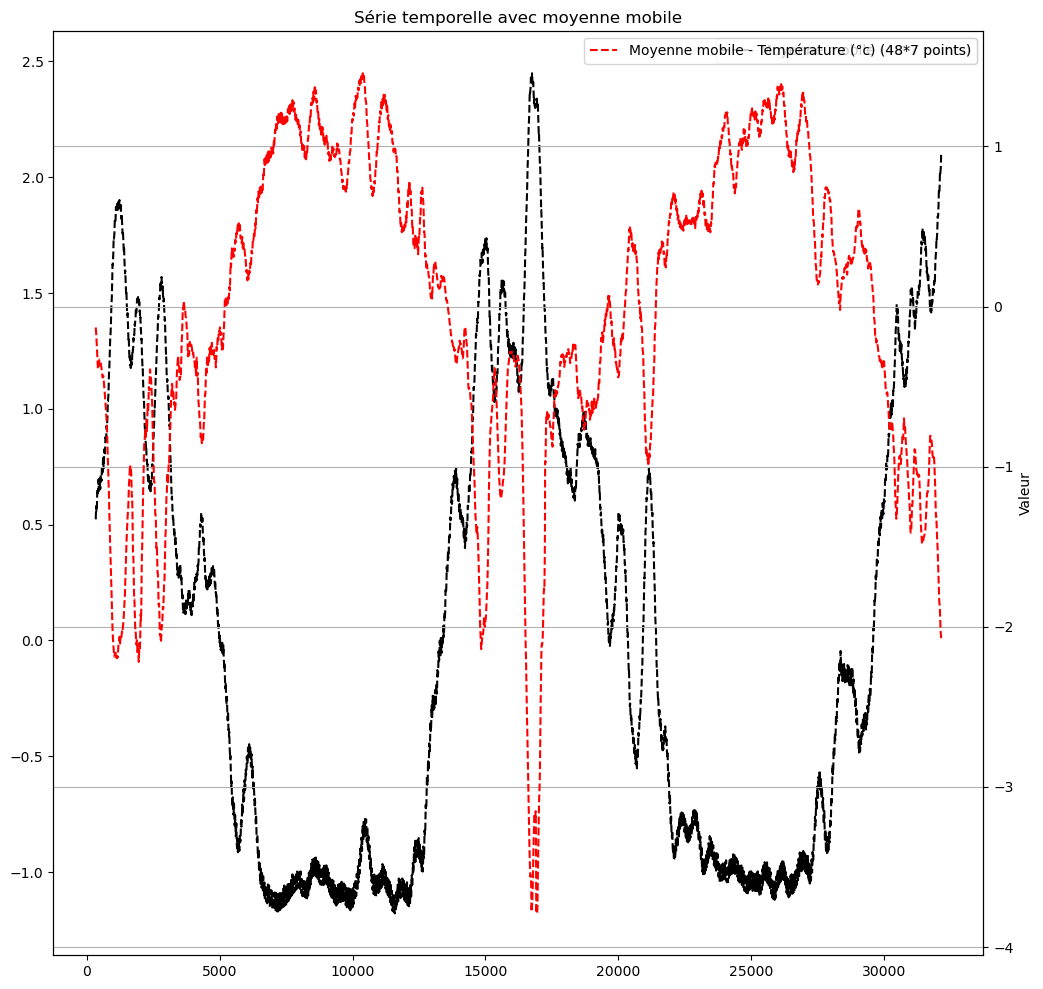

In [16]:

from sklearn.preprocessing import StandardScaler
import numpy as np
# Création du scaler
scaler = StandardScaler()

fig, ax1 = plt.subplots(figsize=(12, 12))
# Calcul de la moyenne sur 48 pas = 1 journée
moyenne_mobile = serie_log.rolling(window=48*7).mean()
moyenne_mobile_T = serie_T_log.rolling(window=48*7).mean()

# Tracé

#ax1.plot(serie_log.shift(7*48), label='Série temporelle - Consommation (Wh)', color='blue')
ax1.plot(scaler.fit_transform(moyenne_mobile), label='Moyenne mobile (48*7 points)', linestyle='--', color='black')
ax1.legend()

ax2 = ax1.twinx()
#ax2.plot(serie_T_log.shift(7*48), label='Série temporelle - Température (°c)', color='yellow')
ax2.plot(scaler.fit_transform(moyenne_mobile_T), label='Moyenne mobile - Température (°c) (48*7 points)', linestyle='--', color='red')
#ax2.plot(scaler.fit_transform(moyenne_mobile_T * moyenne_mobile), label='Série temporelle - Température (°c)', color='yellow')
ax2.legend()

plt.title("Série temporelle avec moyenne mobile")
plt.xlabel("Temps -  pas = 1/2h")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

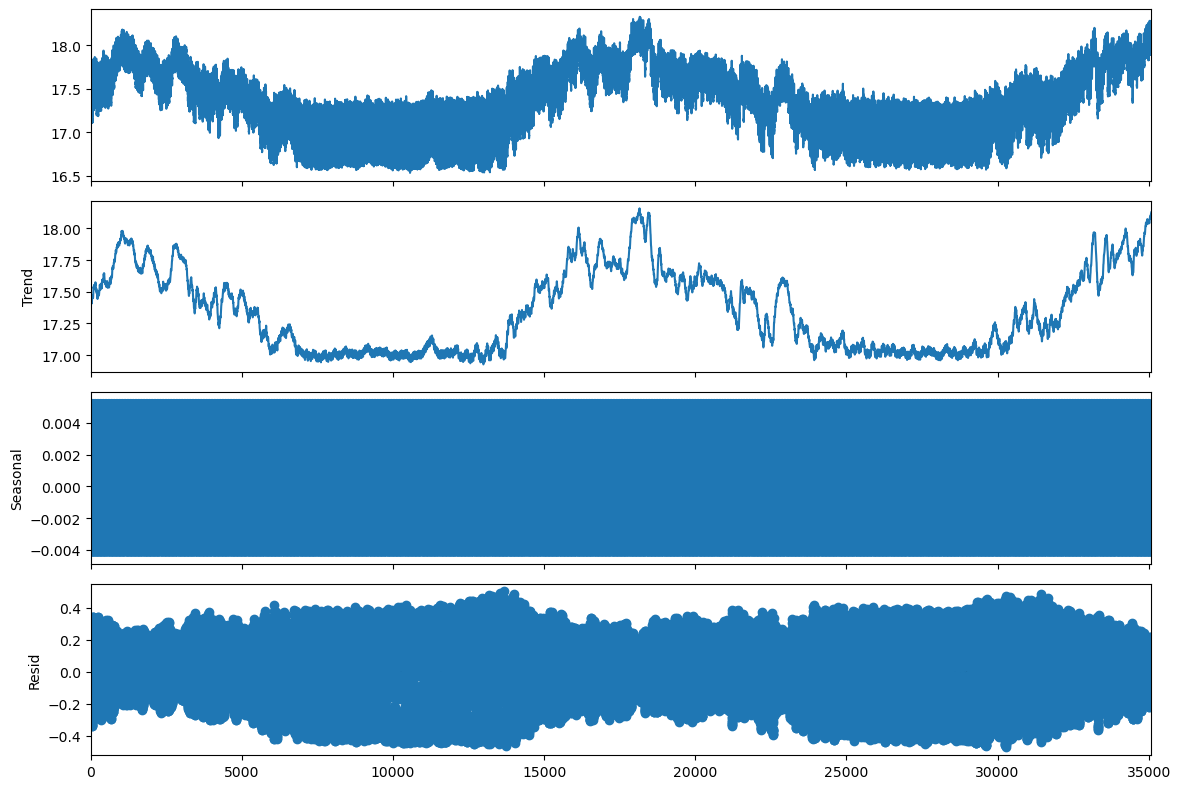

<Figure size 1200x600 with 0 Axes>

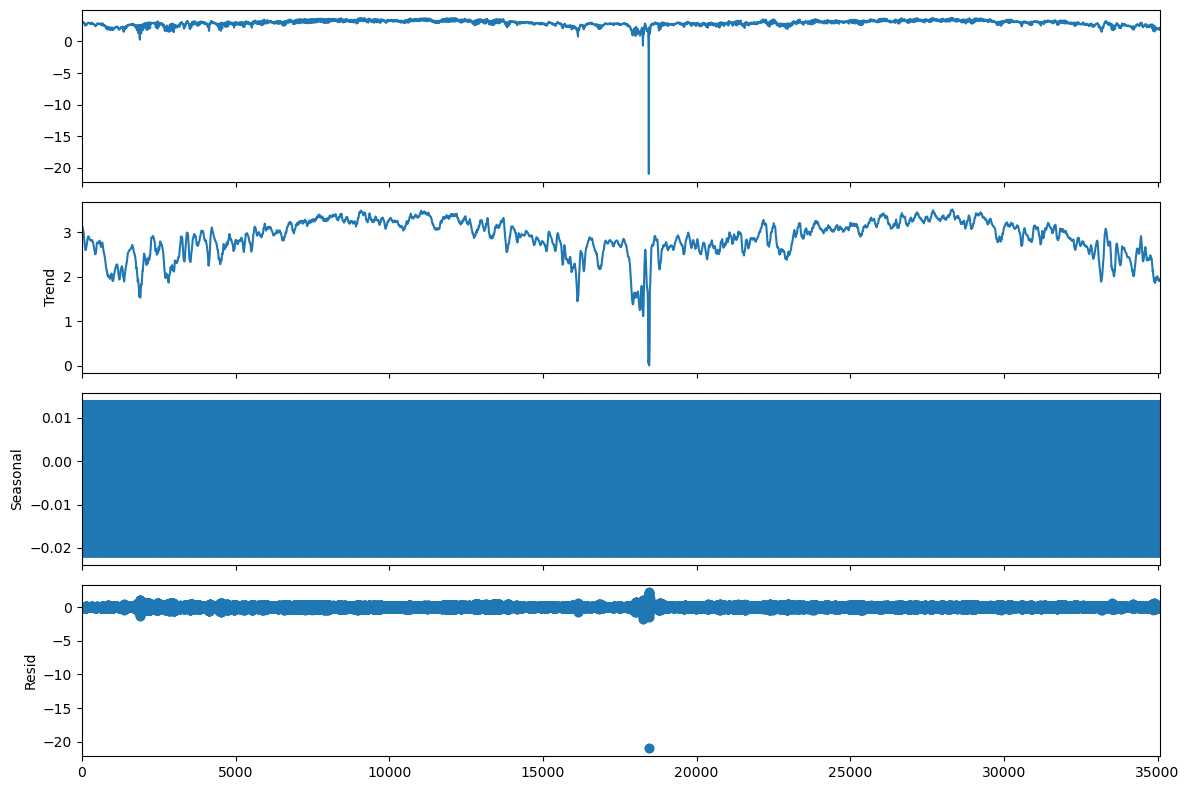

In [17]:
# Décomposition 

from statsmodels.tsa.seasonal import seasonal_decompose 
#serie_1 = serie.diff().dropna()
decomposition = seasonal_decompose(serie_log, period=48,  extrapolate_trend='freq') #model='multiplicative',
plt.figure(figsize=(12, 6))
fig = decomposition.plot()
fig.set_size_inches(12, 8)  # largeur, hauteur en pouces
plt.tight_layout()
plt.show()
plt.show()


decomposition_T = seasonal_decompose(serie_T_log, period=48,  extrapolate_trend='freq') #model='multiplicative',
plt.figure(figsize=(12, 6))
fig = decomposition_T.plot()
fig.set_size_inches(12, 8)  # largeur, hauteur en pouces
plt.tight_layout()
plt.show()
plt.show()


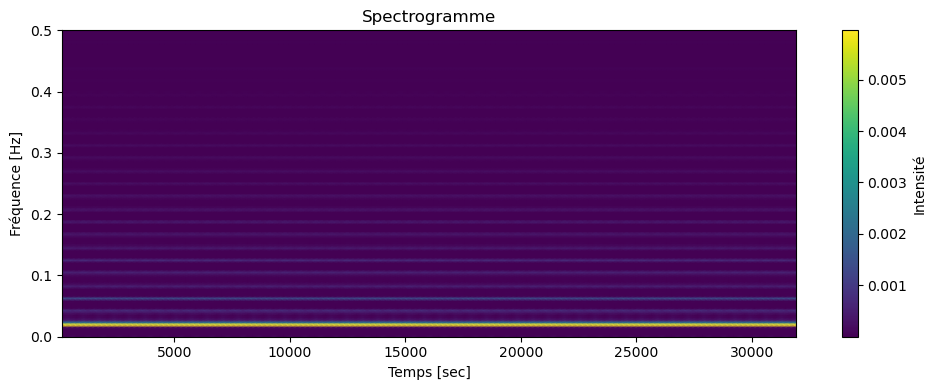

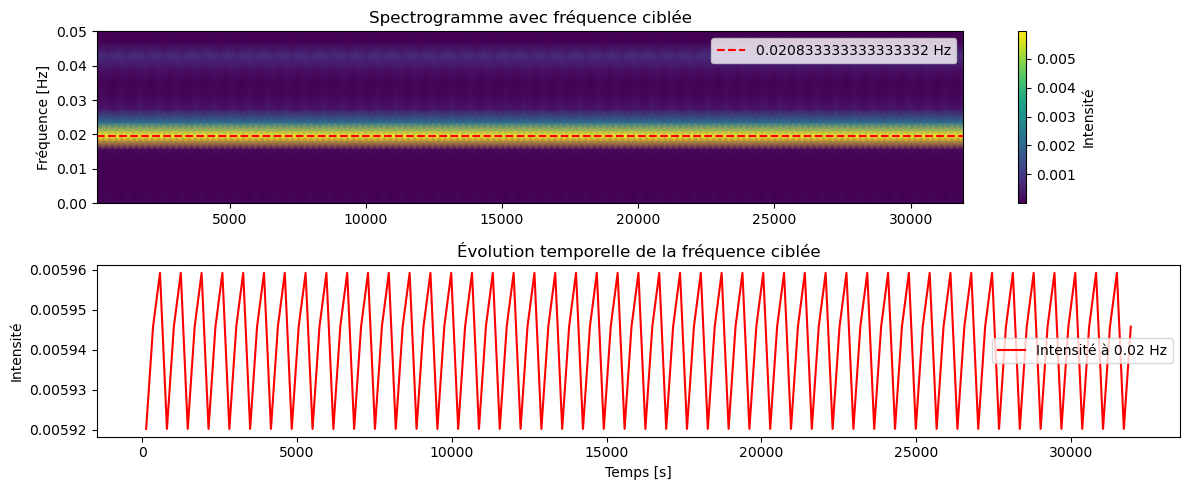

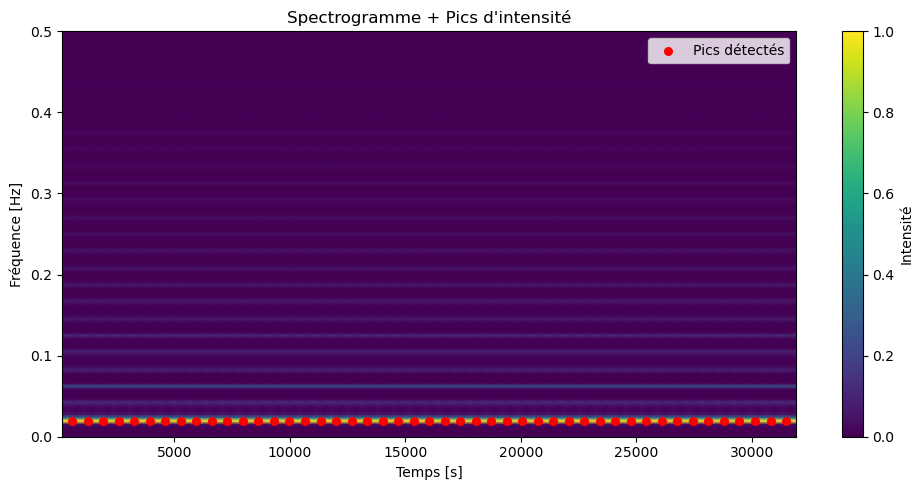

array([[5.76000000e+02, 1.95312500e-02, 5.95924014e-03],
       [1.24800000e+03, 1.95312500e-02, 5.95924014e-03],
       [1.92000000e+03, 1.95312500e-02, 5.95924014e-03],
       [2.59200000e+03, 1.95312500e-02, 5.95924014e-03],
       [3.26400000e+03, 1.95312500e-02, 5.95924014e-03],
       [3.93600000e+03, 1.95312500e-02, 5.95924014e-03],
       [4.60800000e+03, 1.95312500e-02, 5.95924014e-03],
       [5.28000000e+03, 1.95312500e-02, 5.95924014e-03],
       [5.95200000e+03, 1.95312500e-02, 5.95924014e-03],
       [6.62400000e+03, 1.95312500e-02, 5.95924014e-03],
       [7.29600000e+03, 1.95312500e-02, 5.95924014e-03],
       [7.96800000e+03, 1.95312500e-02, 5.95924014e-03],
       [8.64000000e+03, 1.95312500e-02, 5.95924014e-03],
       [9.31200000e+03, 1.95312500e-02, 5.95924014e-03],
       [9.98400000e+03, 1.95312500e-02, 5.95924014e-03],
       [1.06560000e+04, 1.95312500e-02, 5.95924014e-03],
       [1.13280000e+04, 1.95312500e-02, 5.95924014e-03],
       [1.20000000e+04, 1.95312

In [18]:
# Analyse spectrale de la ptremière décompoistion
serie_sp = decomposition_T.seasonal
f, t_spec, Sxx = spectrogram(serie_sp, fs=1 )
plot_spectrogramme(f, t_spec, Sxx)
marquage_raie_spectre( f, t_spec, Sxx, target_freq = 1/48)
identification_peak(f, t_spec, Sxx,threshold = 0.004)

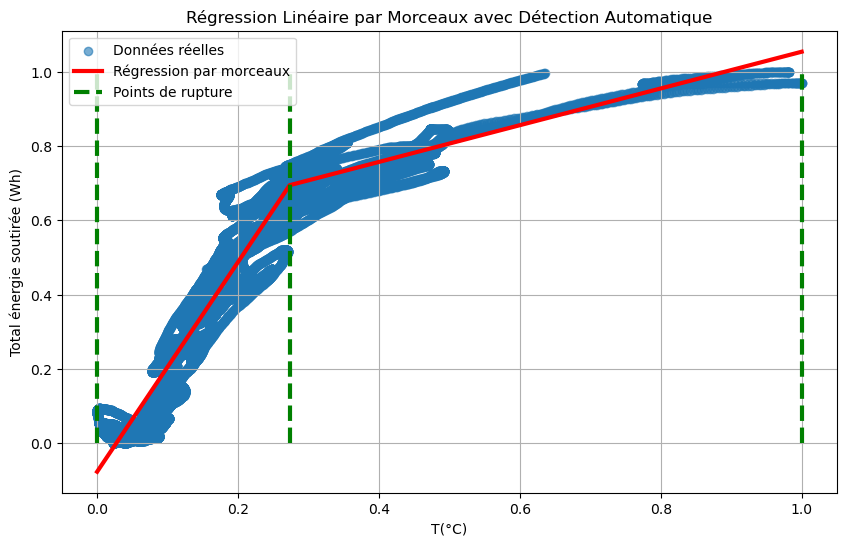

Points de rupture détectés : [0.         0.27316777 1.        ]


In [19]:
# Analyse de regression composante par composante 

trend = decomposition.trend.to_numpy()
seasonal = decomposition.seasonal.to_numpy()
resid = decomposition.resid.to_numpy()

ts = pd.Series(trend, decomposition.trend.index)

decomposition_2 = seasonal_decompose(ts, period=48*7,  extrapolate_trend='freq') #model='multiplicative',

decomposition_T_2 = seasonal_decompose(decomposition_T.trend, period=48*7,  extrapolate_trend='freq') #model='multiplicative',


x =  1/decomposition_T_2.trend
y =decomposition_2.trend

#x = x0.loc[x0<1]
#y = y0.loc[x0<1]

xnorm = (x-np.min(x)) / (np.max(x)- np.min(x))
ynorm = (y-np.min(y)) / (np.max(y)- np.min(y))


x = xnorm
y = ynorm
model = pwlf.PiecewiseLinFit(x,y)

# Détection automatique des points de rupture
# Par exemple : 3 segments (ce paramètre peut être ajusté)
num_segments = 2
breaks = model.fit(num_segments)

# Prédiction des valeurs ajustées

T_hat = np.linspace(min(x), max(x), 1000)
Consommation_hat = model.predict(T_hat)




plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Données réelles', alpha=0.6)
plt.plot(T_hat, Consommation_hat, color='red', label='Régression par morceaux', linewidth=3)
plt.vlines(breaks, ymin=min(y), ymax=max(y), colors='green', linestyles='dashed',linewidth=3, label='Points de rupture')
plt.title('Régression Linéaire par Morceaux avec Détection Automatique')
plt.xlabel('T' + '(°C)')
plt.ylabel('Total énergie soutirée (Wh)')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des points de rupture
print(f"Points de rupture détectés : {breaks}")


In [20]:
TT= [0.2842466,  0.30749337, 0.32447383, 0.36026329, 0.47403319, 0.89565224]
TR = np.exp(1/np.array(TT)) - 10
#TR
model.slopes

array([2.82101309, 0.49405549])

In [21]:
plt.plot(ynorm)
plt.plot(xnorm)

In [22]:
plt.figure(figsize=(10,10))
xnorm = (x-np.min(x)) / (np.max(x)- np.min(x))
ynorm = (y-np.min(y)) / (np.max(y)- np.min(y))


x =  1/decomposition_T_2.trend
y =decomposition_2.trend
plt.scatter(x, y)
plt.plot()

corr_pearson = np.corrcoef(xnorm,ynorm)
corr_pearson

array([[1.        , 0.88966584],
       [0.88966584, 1.        ]])

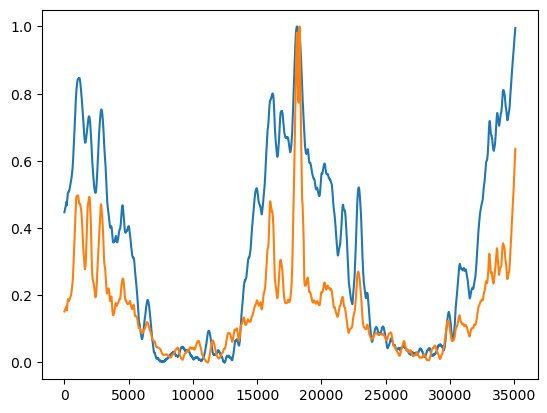

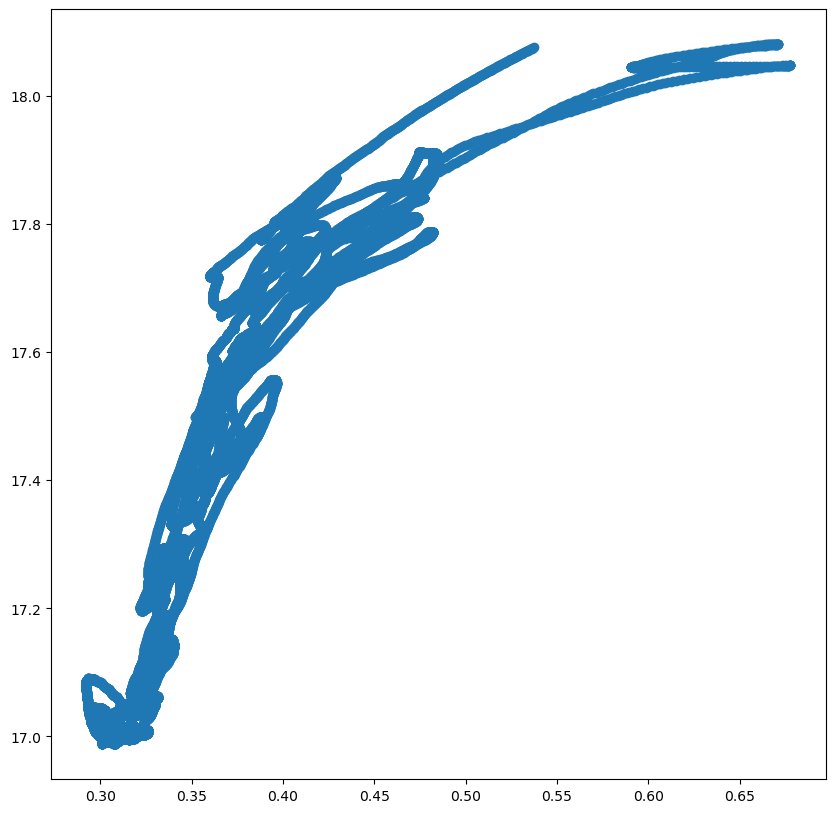

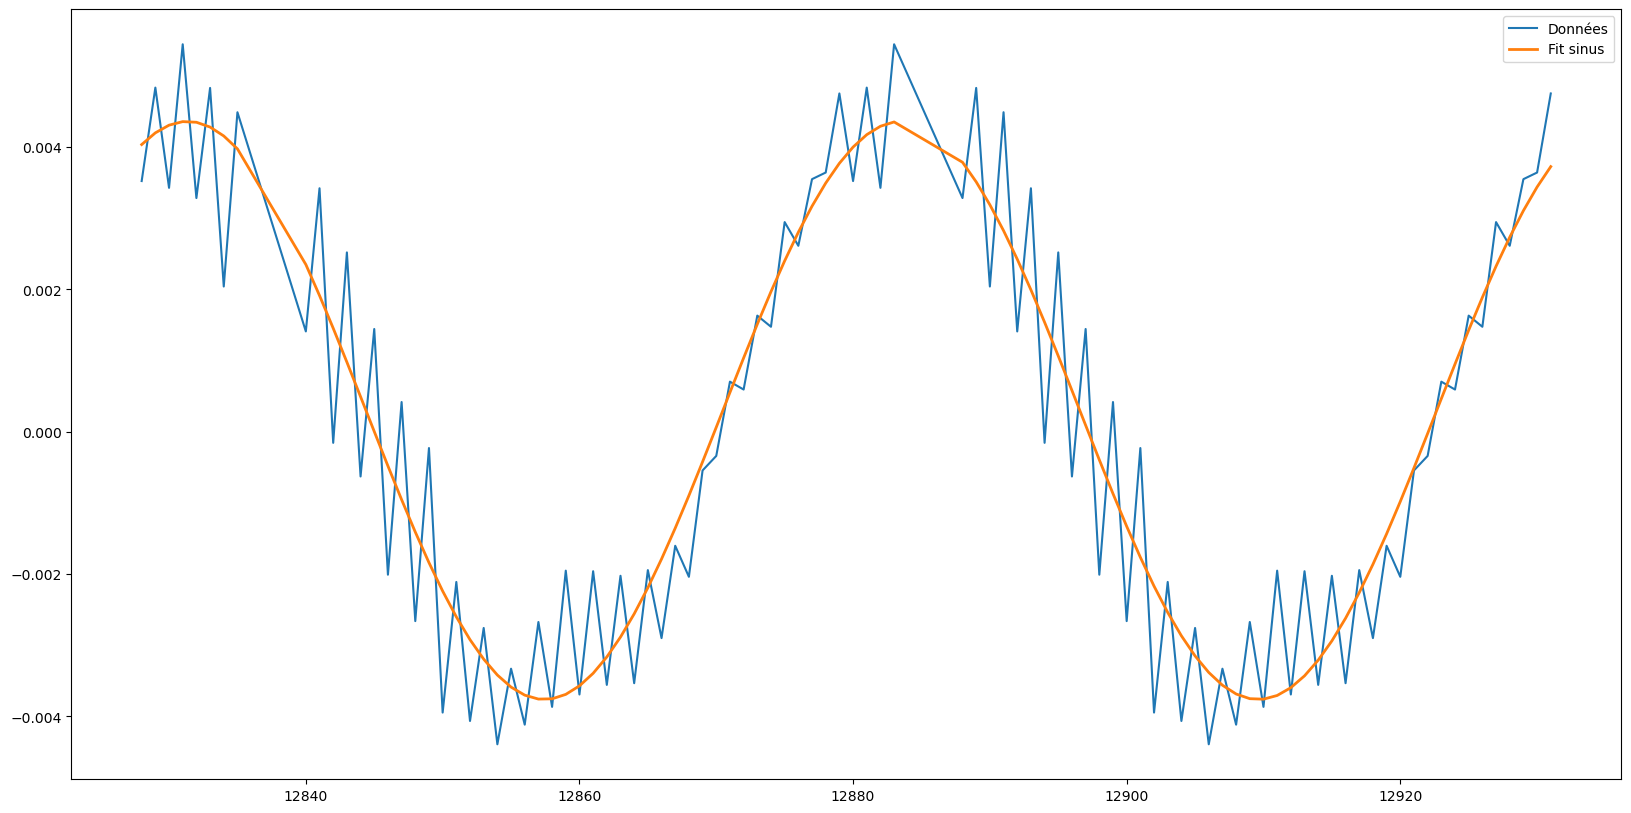

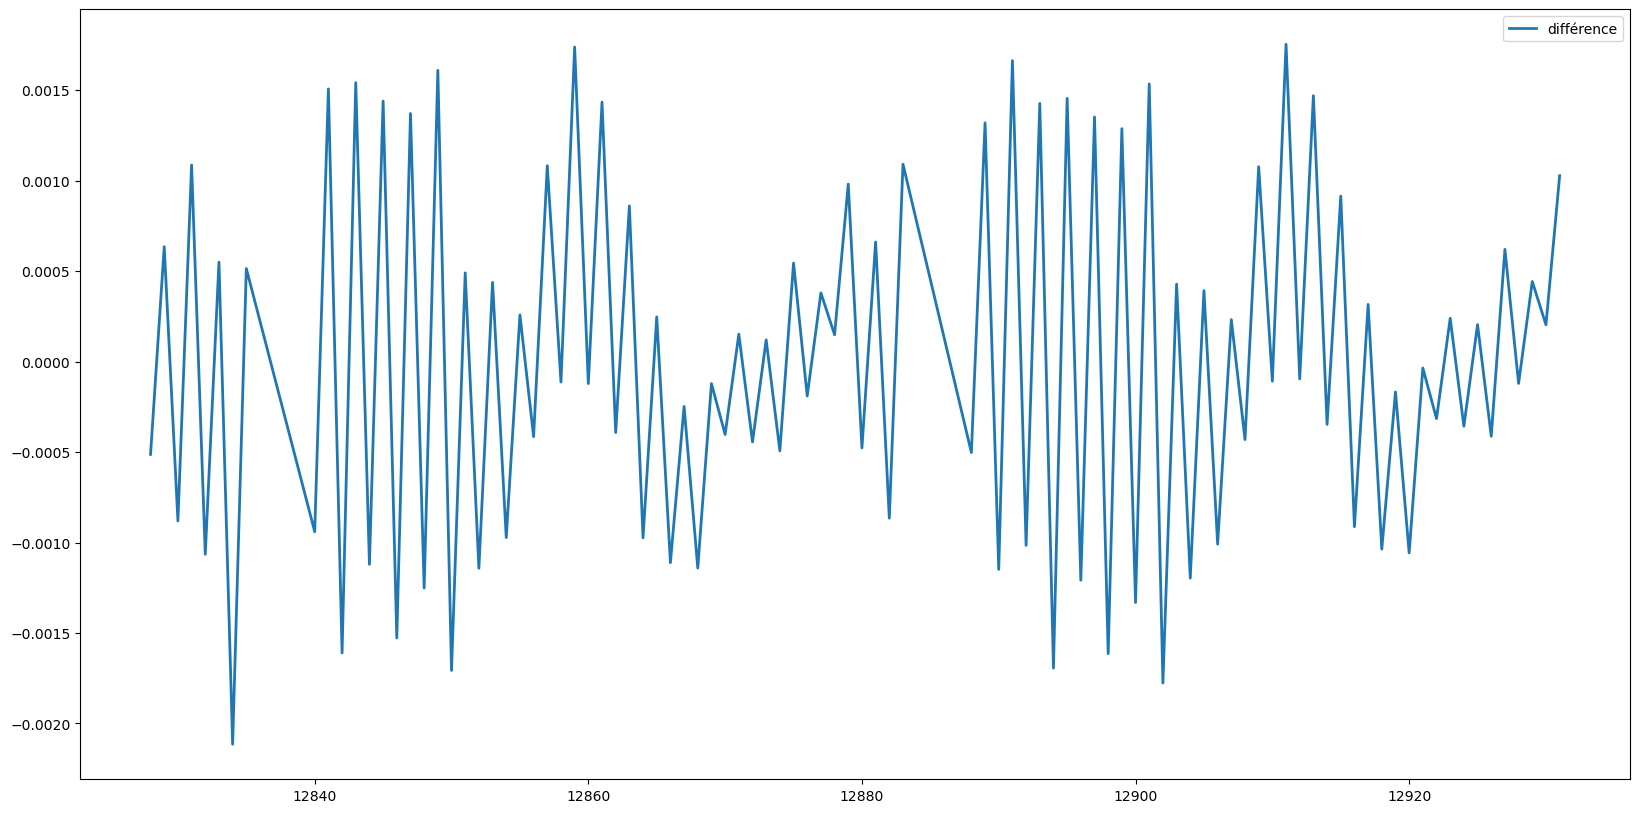

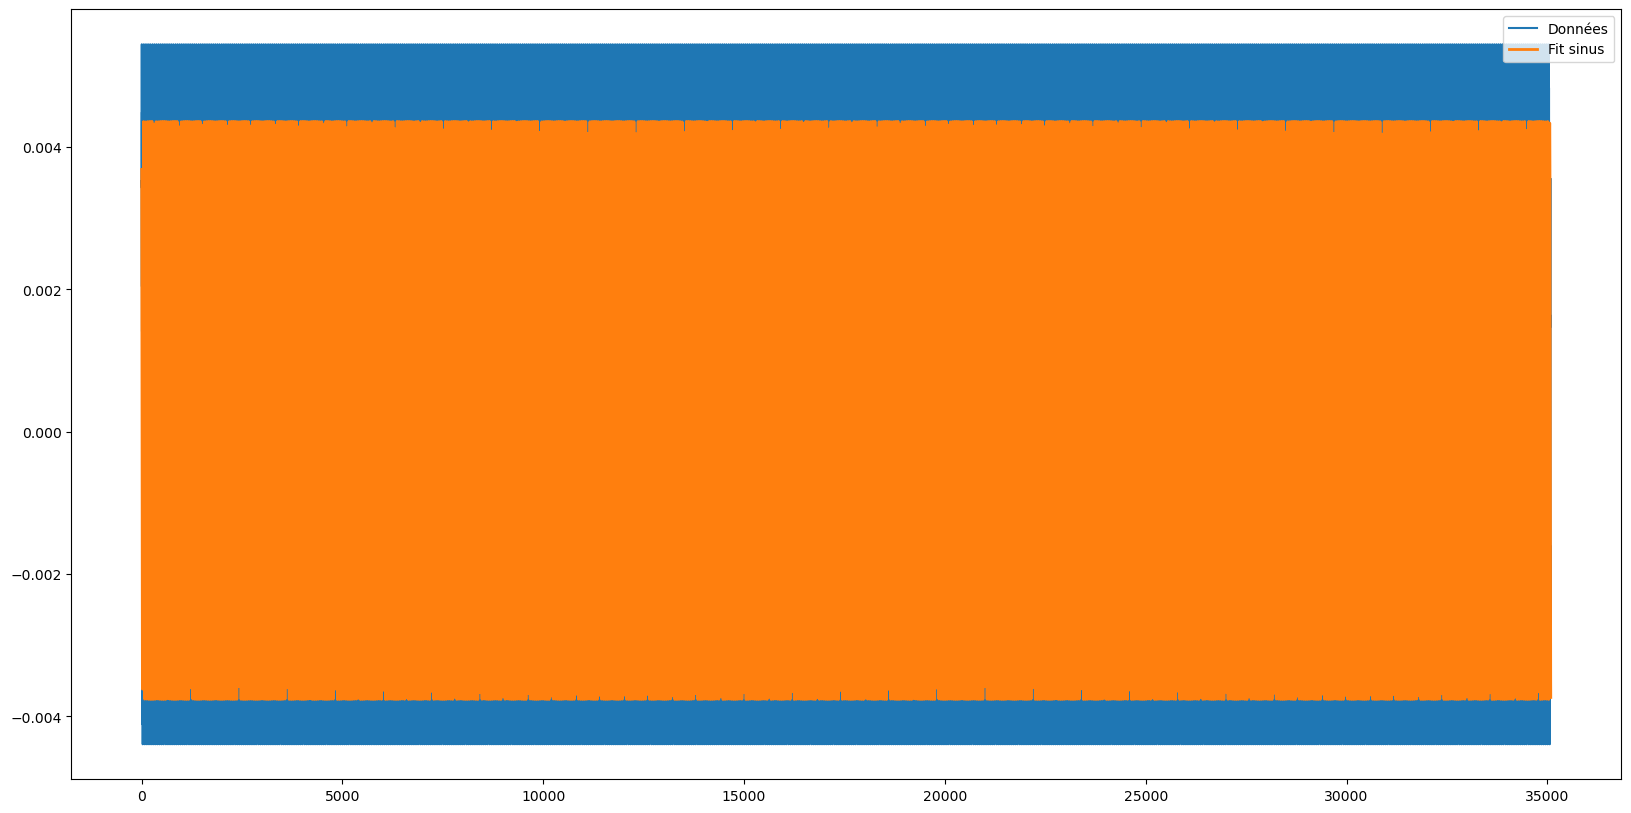

In [23]:
# Ajustement par des sinus de la composante seasonal de la série

from scipy.optimize import curve_fit

seasonal = decomposition.seasonal.to_numpy()
s=35
q = s*7
t = serie_log.iloc[q*48:(q+2)*48].index #serie_log.index 
y = decomposition.seasonal[q*48:(q+2)*48] #seasonal

def sinus(t, A, f, phi, C=1):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Ajustement
params, _ = curve_fit(sinus, t, y,p0=[1, 1/48, 0, 1])
#params = [5e-04, 1/334, 5.37821509e+00, 17.5]
# Prédiction
y_fit = sinus(t, *params)

#print((np.abs(y-y_fit)**2).sum()/len(y))
# Affichage
plt.figure(figsize=(20,10))
plt.plot(t, y, label='Données')
plt.plot(t, y_fit, label='Fit sinus', linewidth=2)
plt.legend()
plt.show()



plt.figure(figsize=(20,10))
#plt.plot(t, y, label='Données')
plt.plot(t, y-y_fit, label='différence', linewidth=2)
plt.legend()
plt.show()

t = serie_log.index 
y = decomposition.seasonal
y_fit_j = sinus(t, *params)

#print((np.abs(y-y_fit)**2).sum()/len(y))
# Affichage
plt.figure(figsize=(20,10))
plt.plot(t, y, label='Données')
plt.plot(t, y_fit_j, label='Fit sinus', linewidth=2)
plt.legend()
plt.show()



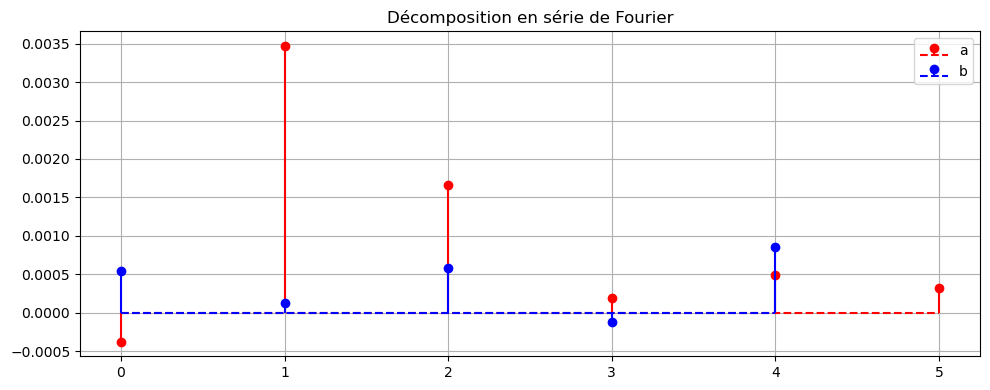

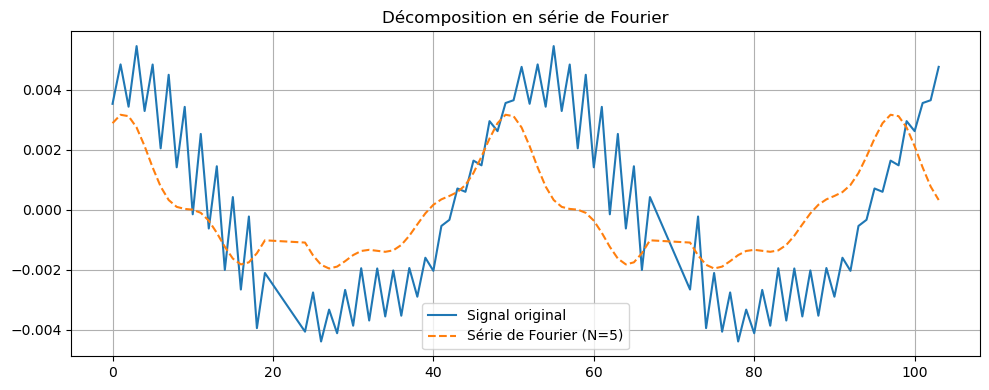

In [24]:
def decomposition_fourier(y, t, T, N):
    f0 = 1 / T
    #y_periode = y[0:T] # serie_sp.values[0:48]

    y_periode = y[0:T+6].rolling(window=7,center=True).mean().dropna()
    t_period = t[0:T]
    # Calcul de la série de Fourier (approchée)
    a =[(1 / T) * np.trapz(y_periode, t_period)]
    partial_sum = a[0]/2
    b=[]

    for n in np.arange(1,N+1):
        an = (2/T)*np.trapz(y_periode * np.cos(2 * np.pi * n * f0 *t_period))
        bn = (2/T)* np.trapz(y_periode * np.sin(2 * np.pi * n * f0 * t_period))
        a.append(an)
        b.append (bn)
        partial_sum = partial_sum + an/2 * np.cos(2 * np.pi * n* f0 * t) + bn/2*np.sin(2 * np.pi * n *f0 * t)
    # Affichage
    plt.figure(figsize=(10, 4))

    plt.stem(a,label='a', linefmt='r-', markerfmt='ro', basefmt='r--')
    plt.stem(b, label='b', linefmt='b-', markerfmt='bo', basefmt='b--')
    plt.title("Décomposition en série de Fourier")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #print(t.shape, y.shape)
    plt.figure(figsize=(10, 4))
 
    plt.plot(t[0:2*T], y[0:2*T], label="Signal original")
    plt.plot(t[0:2*T], partial_sum[0:2*T], label=f"Série de Fourier (N={N})", linestyle='--')
    plt.legend()
    plt.title("Décomposition en série de Fourier")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ajustement par Fourier
t = serie_log.index
y = decomposition.seasonal
#t.shape == y.shape

decomposition_fourier(y,t, T=48, N=5)

valeur estimée
intercept       -0.000164
X_sin            0.002979
X_cos            0.000623

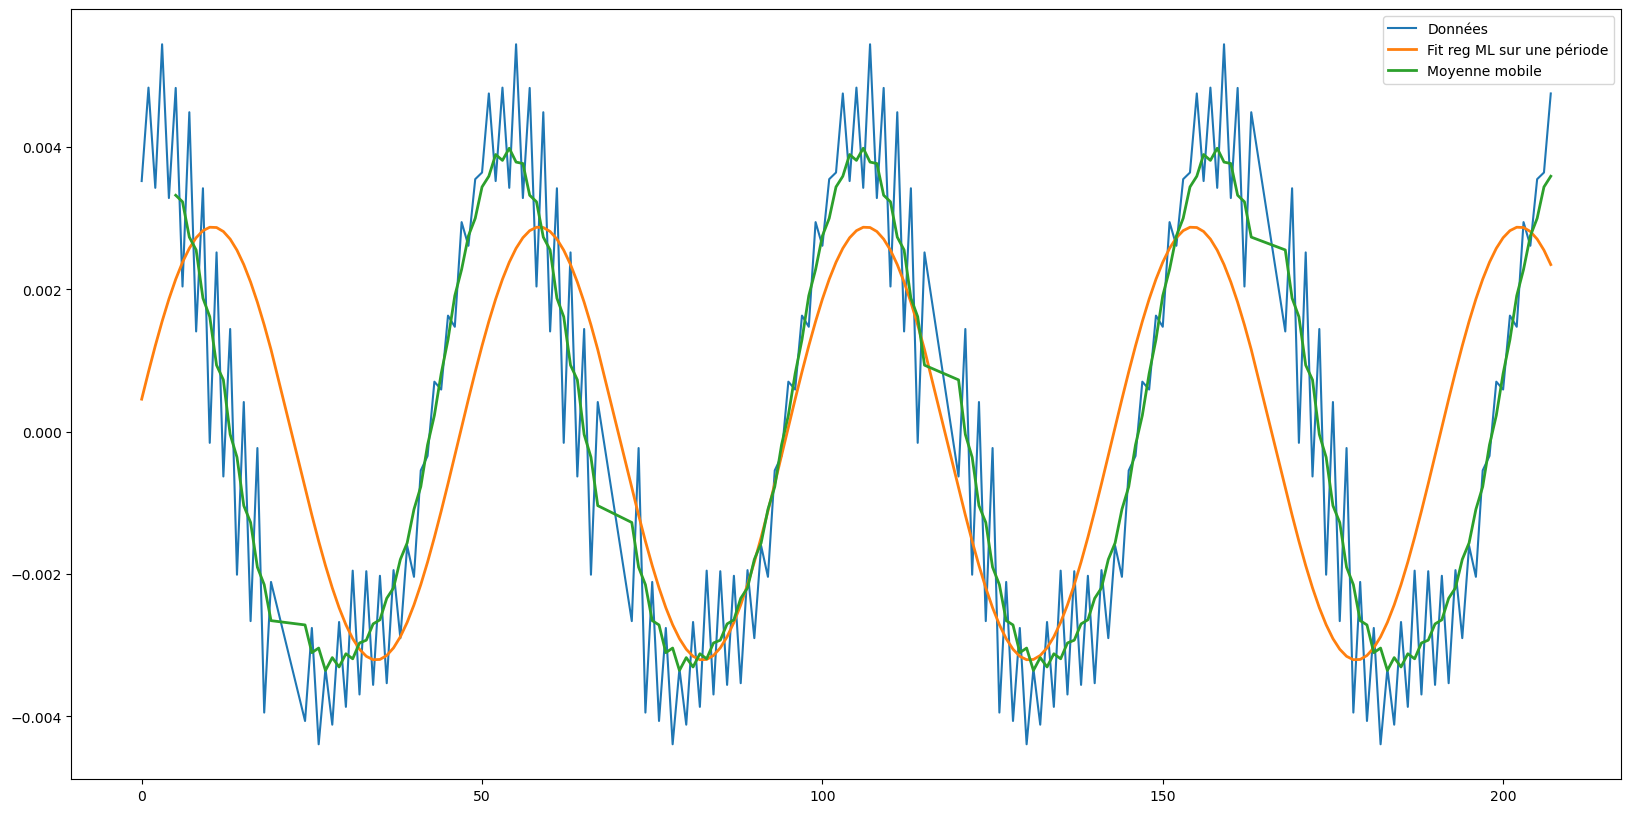

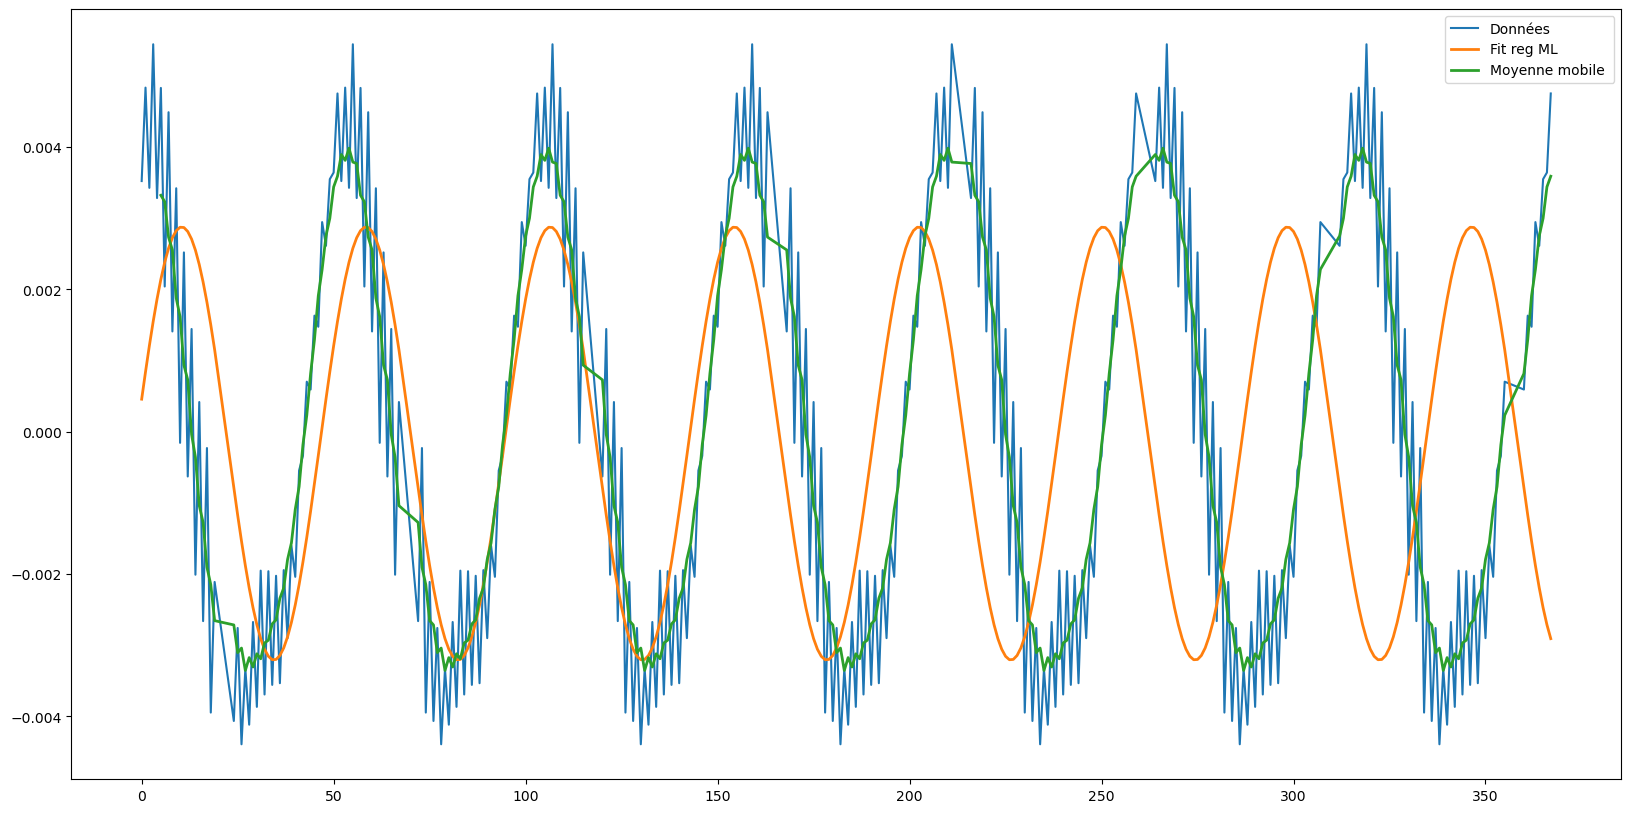

In [25]:
# Par régression linéaire
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

T = 48 # 1j = 48 pas de 1/2 h
f = 1/T
n_periode = 4
n_point_moyenne = 11

t = serie_log.index
X_sin = np.sin(2 * np.pi * f * t) 
X_cos = np.cos(2 * np.pi * f * t) 

t_periode = t[0:n_periode*T]
X_sin_periode = X_sin[0:n_periode*T]
X_cos_periode = X_cos[0:n_periode*T]
X =pd.DataFrame({'X_sin' : X_sin_periode, 'X_cos' : X_cos_periode}, index=t_periode)
y = decomposition.seasonal
y_periode = y[0:n_periode*T]



moyenne_mobile = y.rolling(window=n_point_moyenne,center=True).mean()
moyenne_mobile = moyenne_mobile.dropna()
moyenne_mobile_periode = moyenne_mobile[0:n_periode*T]
lr = LinearRegression()
lr.fit(X,y_periode)
coeffs = list(lr.coef_)
coeffs.insert(0,lr.intercept_)
feats = list(X.columns)
feats.insert(0, 'intercept')



#Autement


display(pd.DataFrame({'valeur estimée' :coeffs}, index=feats))


# Prédiction
y_fit = coeffs[0] + coeffs[1] * X_sin + coeffs[2] * X_cos


plt.figure(figsize=(20,10))
plt.plot(t_periode, y_periode, label='Données')
plt.plot(t_periode, y_fit[0:n_periode*T], label='Fit reg ML sur une période', linewidth=2)
plt.plot(t_periode, moyenne_mobile_periode.shift(n_point_moyenne//2), label='Moyenne mobile ', linewidth=2)
plt.legend()
plt.show()

n_periode_affichage = 7
plt.figure(figsize=(20,10))
plt.plot(t[0:n_periode_affichage*T], y[0:n_periode_affichage*T], label='Données')
plt.plot(t[0:n_periode_affichage*T], y_fit[0:n_periode_affichage*T], label='Fit reg ML ', linewidth=2)
plt.plot(t[0:n_periode_affichage*T], moyenne_mobile.shift(n_point_moyenne//2)[0:n_periode_affichage*T], label='Moyenne mobile ', linewidth=2)
plt.legend()
plt.show()



In [26]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

forceast_long = 28*48
test_long = 48
serie_log_np = decomposition.seasonal

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]

test = serie_annee.iloc[-test_long:]
"""
sarima_conso = auto_arima(train,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=2, m=1, max_P =2, max_Q =2,
                       start_P=0,start_Q=0, seasonal=True,
                       d=1, D=1, trace=True,
                       #with_intercept = True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)"""



#sarima_conso.summary()


# sarima_conso = SARIMAX(train,
#                      order=(2,1,0),
#                      seasonal_order=(1,1,0,48),
#                      enforce_stationarity=False,
#                      enforce_invertibility=False)



sarima_conso = SARIMAX(train,order=(2,1,0),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      

results = sarima_conso.fit(disp=False)
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()



plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prévision', color='red')
plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

ModuleNotFoundError: No module named 'pmdarima'

Première décomposition  $Y_t= S^1_t\times\Theta^1_t\times R^1_t  $

En log :  $log(Y_t)= log(S^1_t)+ log(\Theta^1_t) + log(R^1_t)  $


Deuxième décomposition  $\Theta^1_t= S^2_t\times\Theta^2_t\times R^2_t  $

En log :  $log(Y_t)= log(S^1_t)+log(S^2_t) + log(\Theta^2_t) + log(R^2_t) + log(R^1_t)  $



Deuxième décomposition  $\Theta^2_t= S^3_t\times\Theta^3_t\times R^3_t  $

En log :  $log(Y_t)= log(S^1_t)+log(S^2_t) + +log(S^3_t) + log(\Theta^3_t) + log(R^3_t) + log(R^2_t) + log(R^1_t)  $


La composante $log(S^1_t)$ est quasi-périodique de période $P_1 = 48$ ==> très bonne approximation avec SARIMA(2,1,0)(1,1,0,48)

La composante $log(S^2_t)$ est quasi-périodique de période $P_2 = 7*48$

La composante $log(S^3_t)$ est quasi-périodique de période $P_3 = 365*48$

MAPE: 0.0000000000003497321944145289739811927707699967511709854273149744585680309683084487915039062500000000%


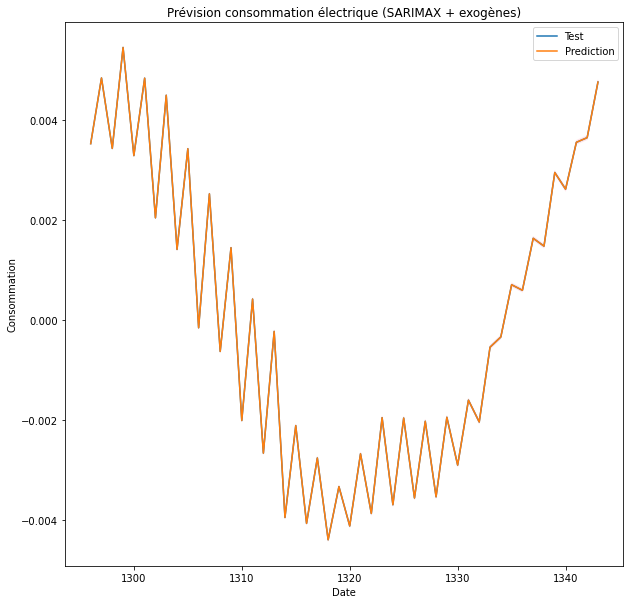

In [ ]:
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label ="Prediction")

plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test, prediction)
print(f"MAPE: {mape:.100%}")

<Figure size 864x432 with 0 Axes>

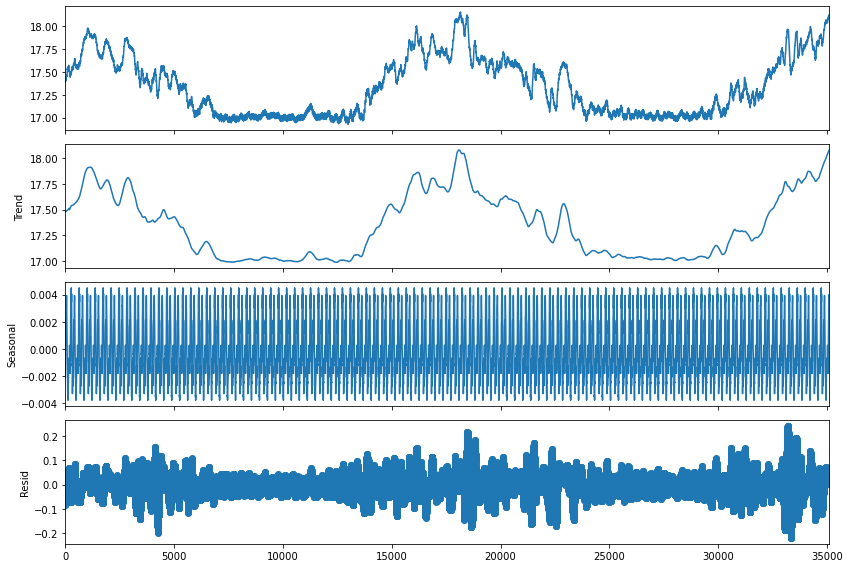

In [ ]:
# Deuxième niveau de décomposition

trend = decomposition.trend.to_numpy()
seasonal = decomposition.seasonal.to_numpy()
resid = decomposition.resid.to_numpy()

ts = pd.Series(trend, decomposition.trend.index)

decomposition_2 = seasonal_decompose(ts, period=48*7,  extrapolate_trend='freq') #model='multiplicative',
plt.figure(figsize=(12, 6))
fig = decomposition_2.plot()
fig.set_size_inches(12, 8)  # largeur, hauteur en pouces
plt.tight_layout()
plt.show()
plt.show()

In [ ]:
decomposition_2.seasonal.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            35076, 35077, 35078, 35079, 35080, 35081, 35082, 35083, 35084,
            35085],
           dtype='int64', name='date', length=32157)

In [ ]:
plt.figure(figsize=(30, 6))
plt.plot(decomposition_2.seasonal[0:14*48])
plt.plot(decomposition_2.seasonal.index[0:14*48], 0.004*np.sin(2*np.pi*np.arange(0,14*48)/(7*48)+np.pi/2))

produit = decomposition_2.seasonal[0:14*48]*np.sin(2*np.pi*np.arange(0,14*48)/(7*48)+np.pi/2)

plt.plot(produit.rolling(window=48,center=True).mean())

NameError: name 'plt' is not defined

In [ ]:
print(np.argmax(decomposition_2.seasonal[300:350]))

49


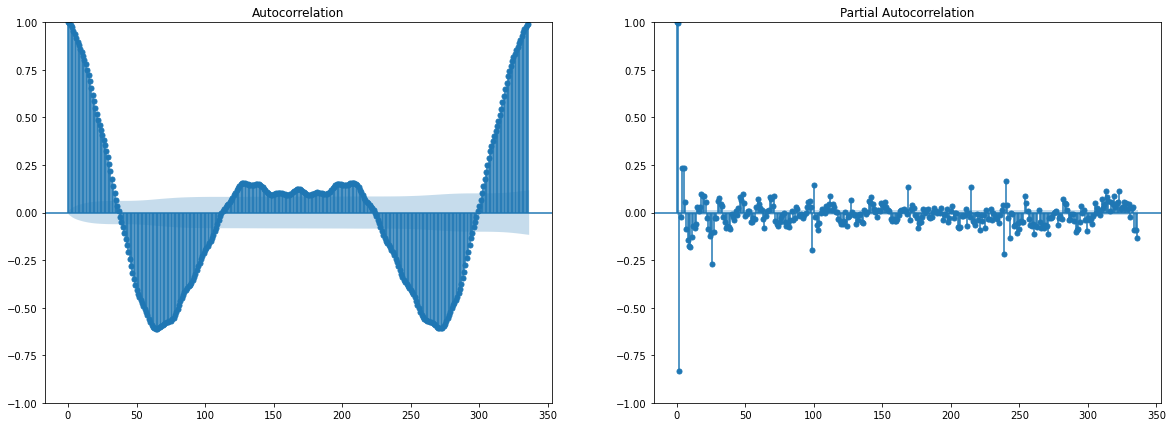

In [ ]:

serie_log_np = decomposition_2.seasonal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(serie_log_np, lags = 7*48, ax=ax1)
plot_pacf(serie_log_np, lags = 7*48, ax=ax2)
plt.show()

In [ ]:
forceast_long = 4*7*48
test_long = 7*48
serie_log_np = decomposition_2.seasonal

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0:forceast_long] #np.arange(0,forceast_long,24)
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]

test = serie_annee.iloc[-test_long:]

"""
sarima_conso = auto_arima(train,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=2,m=7, max_P =5, max_Q =5,
                       start_P=0,start_Q=0, seasonal=True,
                       d=1, D=1, trace=True,
                       with_intercept = True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
 


#sarima_conso.summary()


sarima_conso = SARIMAX(train,
                      order=(2,1,0),
                      seasonal_order=(1,1,0,7*48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

"""

sarima_conso = SARIMAX(train,order=(2,1,0),
                     seasonal_order=(1,1,0,7*48),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
C = True                  
if C:
    results = sarima_conso.fit(train)
    forecast = results.get_forecast(steps=len(test))
    prediction = forecast.predicted_mean
    conf_int = forecast.conf_int()

    prediction.index = test.index
    plt.figure(figsize=(14, 6))
    plt.plot(train, label = 'Training data')
    plt.plot(test, label ='Test')
    plt.plot(prediction, label='Prévision', color='red')
    plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
    plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
    plt.xlabel("Date")
    plt.ylabel("Consommation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout() 
    plt.show()


ValueError: Input contains NaN.

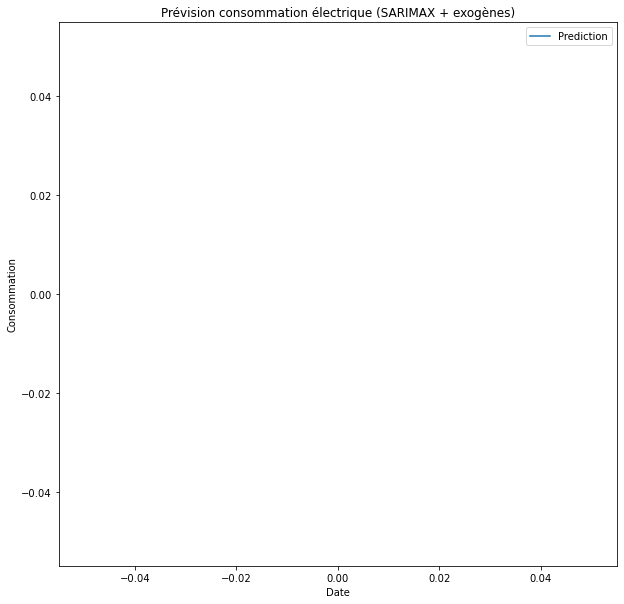

In [ ]:
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
#plt.plot(test, label ='Test')
plt.plot(prediction, label ="Prediction")

plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test, prediction)
print(f"MAPE: {mape:.100%}")

In [ ]:
prediction

1008   NaN
1009   NaN
1010   NaN
1011   NaN
1012   NaN
        ..
1339   NaN
1340   NaN
1341   NaN
1342   NaN
1343   NaN
Name: predicted_mean, Length: 336, dtype: float64

  4%|▎         | 18/500 [00:00<00:02, 178.17trial/s, best loss: 8.162155562952323e-06]

100%|██████████| 500/500 [00:11<00:00, 42.76trial/s, best loss: 4.262376636550811e-06]
Fitted parameters:


'a_0=-0.00, a_1=0.00, \\omega=0.04, \\phi=0.01'

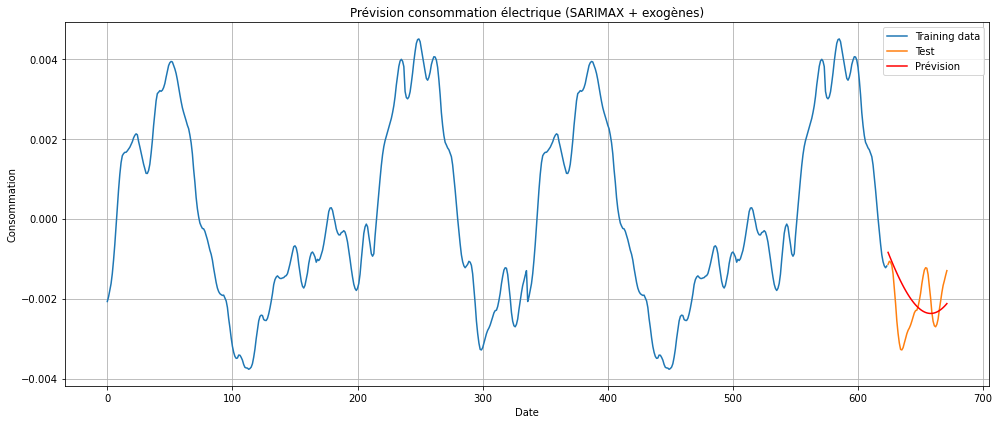

In [ ]:
import numpy as np
import logging
from hyperopt import hp, tpe, Trials, fmin
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from IPython.display import display, Math

class RegressionForTrigonometric(BaseEstimator, TransformerMixin):
    def __init__(self, omega_range=(0, 10), phi_range=(-np.pi, np.pi)):
        # Initialization of model parameters
        self.omega_range = omega_range
        self.phi_range = phi_range
        self.model = LinearRegression()
        self.best_parameters = {}

    def opt_trig_params(self, X, y, **kwargs):
        space = [hp.uniform('omega', self.omega_range[0], self.omega_range[1]),
                 hp.uniform('phi', self.phi_range[0], self.phi_range[1])]
        tpe_algorithm = tpe.suggest
        tpe_trials = Trials()

        # function to minimize: MSE
        def objective(omega, phi): return np.mean((self.a0 + self.a1 * self.trig_func(omega * X + phi) - y) ** 2)

        def objective2(args): return objective(*args)
        logging.debug('Performing tpe algorithm to fng optimal omega and phi')
        tpe_best = fmin(fn=objective2, space=space, algo=tpe_algorithm, trials=tpe_trials, **kwargs)

        return tpe_best

    def _fit_trig_params(self, X, y, **kwargs):
        """
        Search for best trigonometric values omega and phi using hyperopt.
        :param X:
        :param y:
        :param kwargs: hyperopt.fmin input params
        :return:
        """
        self.a1 = (y.max() - y.min()) / 2.
        self.a0 = y.mean()
        trig_params = self.opt_trig_params(X, y, **kwargs)
        self.best_parameters = trig_params

    def _transform_params(self, X):
        """
        Convert from scalar to vectors for input in Regression model
        :param X:
        :return:
        """
        omega = self.best_parameters['omega'] * np.ones(len(X))
        phi = self.best_parameters['phi'] * np.ones(len(X))
        x_new = self.trig_func(omega * X + phi)
        x_new = x_new[:, np.newaxis]
        return x_new

    def _fit(self, X, y, trig_func='cos', **kwargs):
        """
        Get the bests omega and phi. Transform row vector to column vector as input for the regression
        :param X:
        :param y:
        :param kwargs: hyperopt.fmin input params
        :return:
        """
        if trig_func == 'cos':
            self.trig_func = np.cos
        elif trig_func == 'sin':
            self.trig_func = np.sin
        else:
            raise Exception('trig_func must be sin or cos.')

        self._fit_trig_params(X, y, **kwargs)
        X_transf = self._transform_params(X)
        self.model.fit(X_transf, y)
        self.best_parameters['intercept'] = self.model.intercept_  # shift
        self.best_parameters['amplitude'] = self.model.coef_[0]  # Amplitude of signal
        return self

    def predict(self, X):
        X_transf = self._transform_params(X)
        ypred = self.model.predict(X_transf)
        return ypred

    def fit_sin(self, X, y, **kwargs):
        # default domain of the Sine function "phi in (0, 2pi)"
        if self.phi_range == (-np.pi, np.pi):
            logging.debug('The defined domain of Sine function is (0, 2*pi)')
            self.phi_range = (0, 2 * np.pi)
        return self._fit(X, y, trig_func='sin', **kwargs)

    def fit_cos(self, X, y, **kwargs):
        return self._fit(X, y, trig_func='cos', **kwargs)
    

forceast_long = 14*48
test_long = 48
serie_log_np = decomposition_2.seasonal

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]

test = serie_annee.iloc[-test_long:]

trig_reg = RegressionForTrigonometric(omega_range=(2*np.pi/(7*48), 4*np.pi/(7*48)))



trig_reg.fit_sin(train.index.to_numpy(), train.values, max_evals=500)

print('Fitted parameters:')
display('a_0={intercept:.2f}, a_1={amplitude:.2f}, \\omega={omega:.2f}, \\phi={phi:.2f}'.format(**trig_reg.best_parameters))



prediction = trig_reg.predict(test.index.to_numpy())
prediction = pd.Series(prediction, index = test.index)

plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prévision', color='red')
#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

In [ ]:
print(hp.uniform('omega', 0, 1))

0 float
1   hyperopt_param
2     Literal{omega}
3     uniform
4       Literal{0}
5       Literal{1}


<ipython-input-80-36153770d62b>:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_new = x_new[:, np.newaxis]


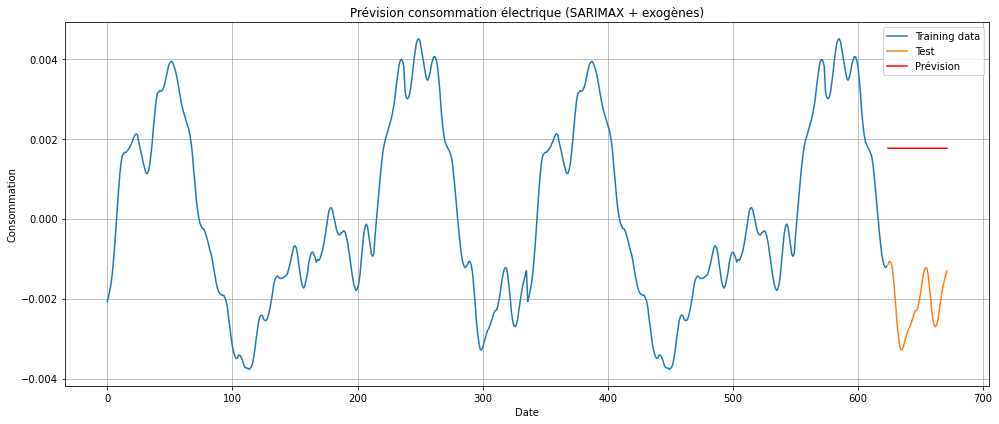

In [ ]:

prediction = trig_reg.predict(test)
prediction = pd.Series(prediction, index = test.index)

plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prévision', color='red')
#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

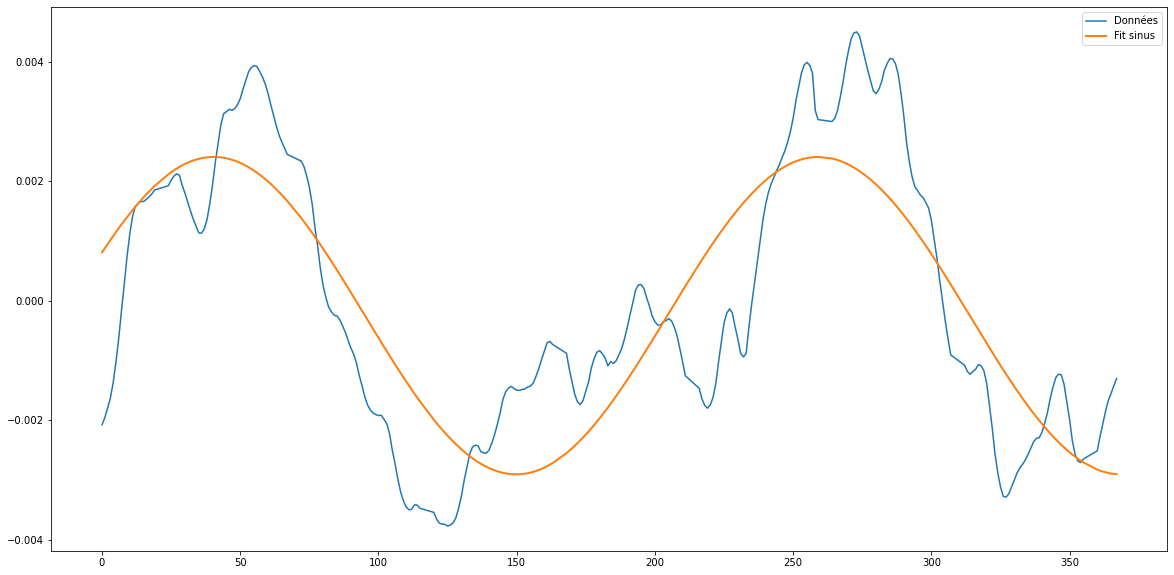

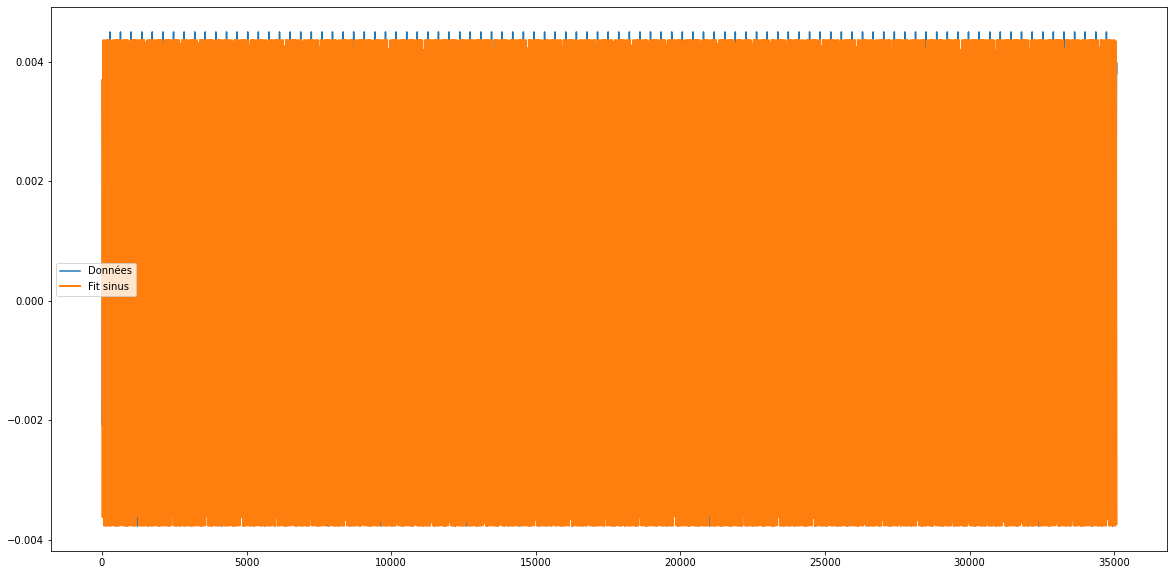

In [ ]:

seasonal = decomposition_2.seasonal.to_numpy()


t =serie_log.iloc[0*48:7*48].index #serie_log.iloc[0*48:56*48].index
y=seasonal[0*48:7*48]

def sinus(t, A, f, phi, C=1):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Ajustement
params, _ = curve_fit(sinus, t, y,p0=[1, 1/(7*48), 0, 1])
#params = [5e-04, 1/334, 5.37821509e+00, 17.5]
# Prédiction
y_fit = sinus(t, *params)

#print((np.abs(y-y_fit)**2).sum()/len(y))
# Affichage
plt.figure(figsize=(20,10))
plt.plot(t, y, label='Données')
plt.plot(t, y_fit, label='Fit sinus', linewidth=2)
plt.legend()
plt.show()


t = serie_log.index 
y = seasonal
y_fit_sem = sinus(t, *params)

#print((np.abs(y-y_fit)**2).sum()/len(y))
# Affichage
plt.figure(figsize=(20,10))
plt.plot(t, y, label='Données')
plt.plot(t, y_fit_j, label='Fit sinus', linewidth=2)
plt.legend()
plt.show()

<Figure size 864x432 with 0 Axes>

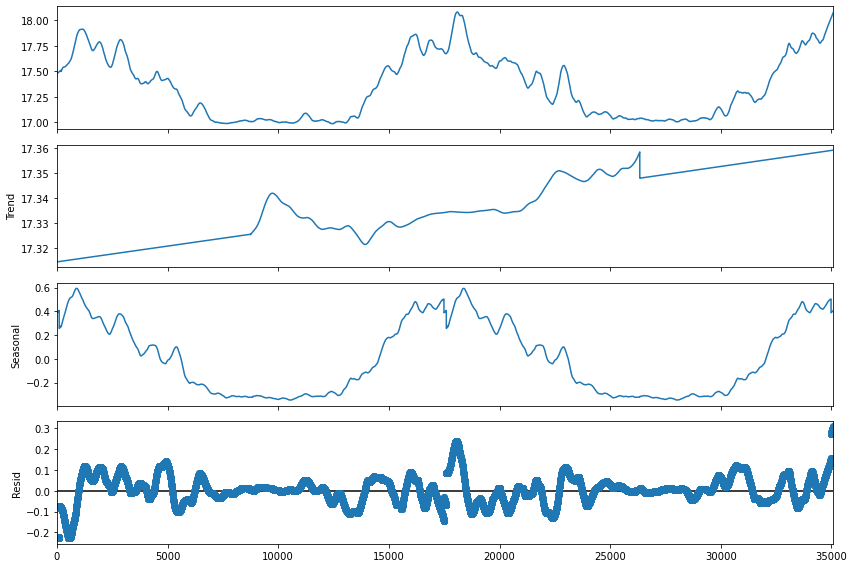

In [ ]:
trend = decomposition_2.trend.to_numpy()
seasonal = decomposition_2.seasonal.to_numpy()
resid = decomposition_2.resid.to_numpy()

ts = pd.Series(trend, serie_log.index)

decomposition_3 = seasonal_decompose(ts, period=48*334, extrapolate_trend='freq') #model='multiplicative', 
plt.figure(figsize=(12, 6))
fig = decomposition_3.plot()
fig.set_size_inches(12, 8)  # largeur, hauteur en pouces
plt.tight_layout()
plt.show()
plt.show()

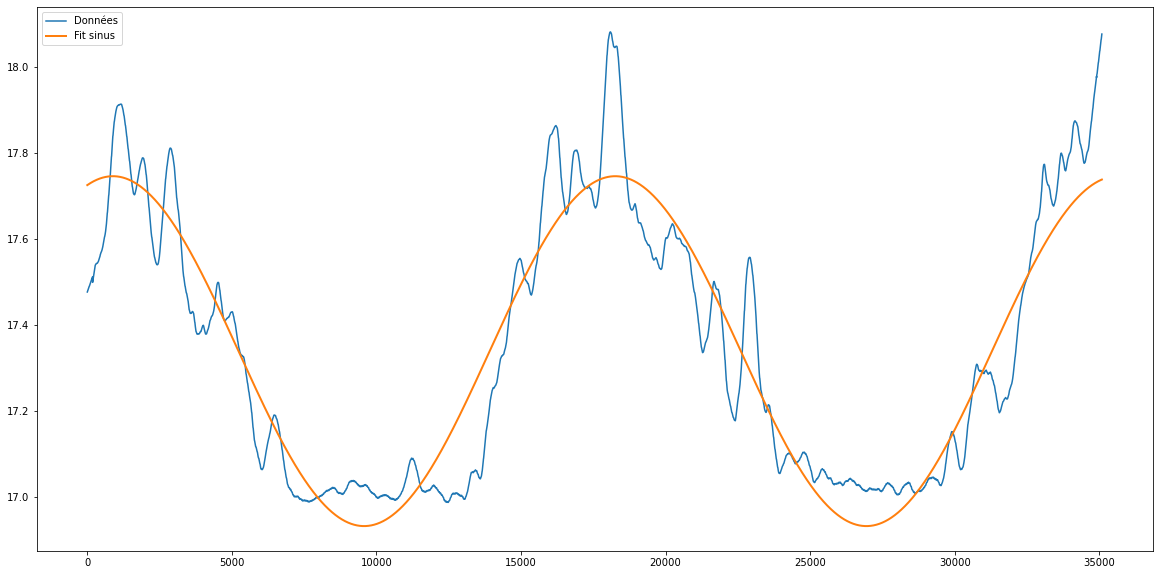

In [ ]:

from scipy.optimize import curve_fit

trend = decomposition_2.trend.to_numpy()
seasonal = decomposition_2.seasonal.to_numpy()
resid = decomposition_2.resid.to_numpy()

t =serie_log.index #serie_log.iloc[0*48:56*48].index
y=trend #decomposition.seasonal[0*48:56*48]

def sinus(t, A, f, phi, C=1):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Ajustement
params, _ = curve_fit(sinus, t, y,p0=[2e7, 1/(365*48), 0, 40000000])
#params = [2e7, 1/(365*48), 1.8, 40000000]
# Prédiction
y_fit_annee = sinus(t, *params)

#print((np.abs(y-y_fit)**2).sum()/len(y))
# Affichage
plt.figure(figsize=(20,10))
plt.plot(t, y, label='Données')
plt.plot(t, y_fit_annee, label='Fit sinus', linewidth=2)
plt.legend()
plt.show()

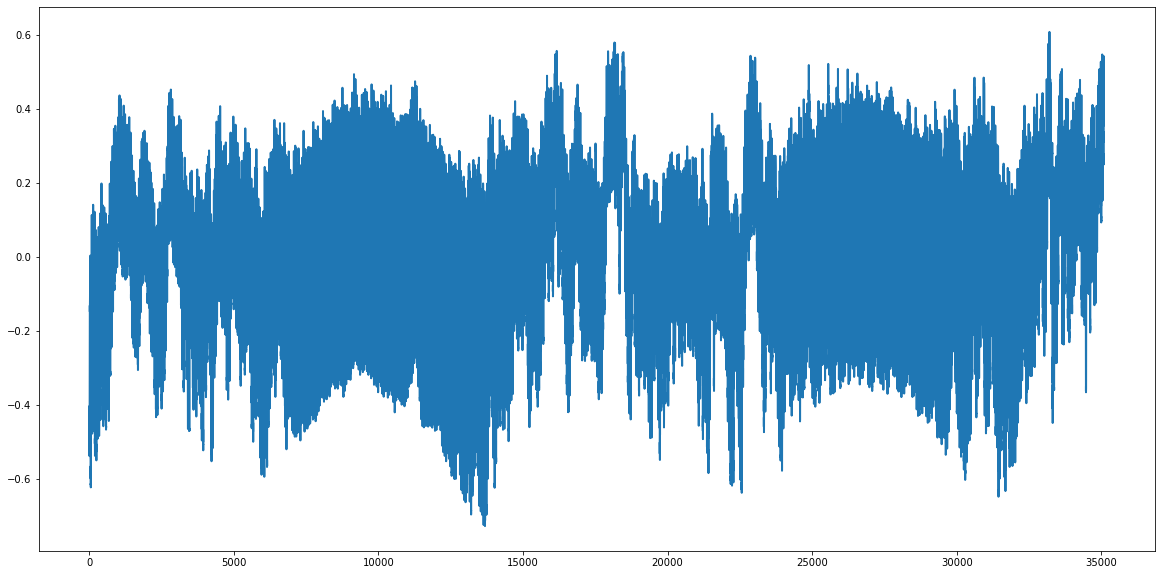

In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(t, y, label='Données')
plt.plot(t, serie_log['consommation']-(y_fit_annee+y_fit_j+y_fit_sem), linewidth=2)

plt.show()

consommation
date               
0        32457452.0
1        33427025.0
2        30720205.0
3        31645442.0
4        29879884.0
...             ...
35081    75666177.0
35082    68646786.0
35083    70551622.0
35084    64593691.0
35085    66395836.0

[32158 rows x 1 columns]

In [ ]:
print('params=',params)

params= [1.36893964e-03 1.91269385e-02 5.37821509e+00 1.00004004e+00]


In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

forceast_long = 28*48
test_long = 48
serie_log_np = serie_log['consommation']- (y_fit_annee+y_fit_j+y_fit_sem)

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]

test = serie_annee.iloc[-test_long:]
sarima_conso = auto_arima(train,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=2, m=1, max_P =2, max_Q =2,
                       start_P=0,start_Q=0, seasonal=True,
                       d=1, D=1, trace=True,
                       #with_intercept = True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)



sarima_conso.summary()





Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3651.592, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2939.355, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3414.587, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3122.917, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2941.300, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4367.455, Time=5.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4237.865, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4974.141, Time=5.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4575.499, Time=4.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-4976.134, Time=1.93 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4577.393, Time=1.67 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4369.569, Time=2.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3653.434, Time=1.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 27.021 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1296
Model:               SARIMAX(2, 1, 2)   Log Likelihood                2493.067
Date:                Tue, 08 Apr 2025   AIC                          -4976.134
Time:                        17:26:38   BIC                          -4950.303
Sample:                             0   HQIC                         -4966.440
                               - 1296                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0679      0.039     -1.737      0.082      -0.145       0.009
ar.L2          0.6615      0.018     36.459      0.000       0.626       0.697
ma.L1         -0.3395      0.025    -13.317      0.000      -0.389      -0.290
ma.L2          0.6403      0.023     27.862      0.000       0.595       0.685
sigma2         0.0012   4.52e-05     27.468      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   5.00   Jarque-Bera (JB):                53.61
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sarima_conso = SARIMAX(train,
                      order=(2,1,0),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)



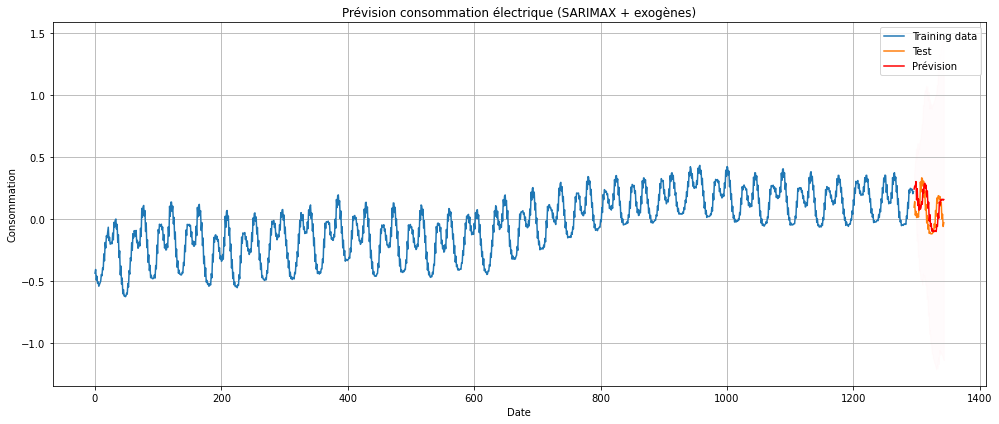

In [ ]:


results = sarima_conso.fit(disp=False)
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()



plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prévision', color='red')
plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

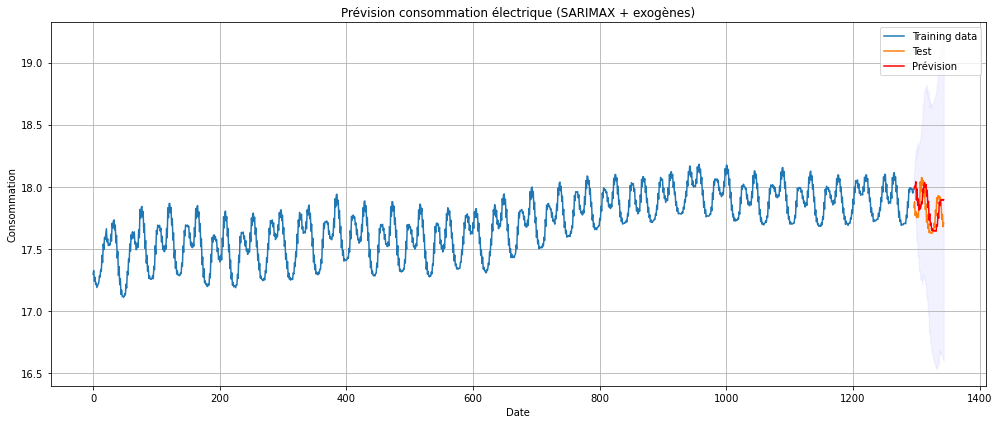

In [ ]:

part_perd =y_fit_annee + y_fit_j + y_fit_sem

#part_perd.index = np.arange(len(part_perd))
part_perd_train = part_perd[0:len(train)] 
part_perd_test = part_perd[-test_long:]

#test.index = test.index + len(train)
#prediction.index = prediction.index + len(train)
plt.figure(figsize=(14, 6))
#plt.plot(part_perd_train*np.exp(train), label = 'Training data')
plt.plot(part_perd_train+train, label = 'Training data')
plt.plot(part_perd_test+test, label ='Test')
plt.plot(part_perd_test+prediction, label='Prévision', color='red')
plt.fill_between(prediction.index, part_perd_test+conf_int.iloc[:, 0], part_perd_test+conf_int.iloc[:, 1], color='b', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
           dtype='int64')

In [ ]:
mape = mean_absolute_percentage_error(np.exp(test), np.exp(prediction))
print(f"MAPE: {mape:.2%}")

MAPE: 12.74%


MAPE: 12.74%


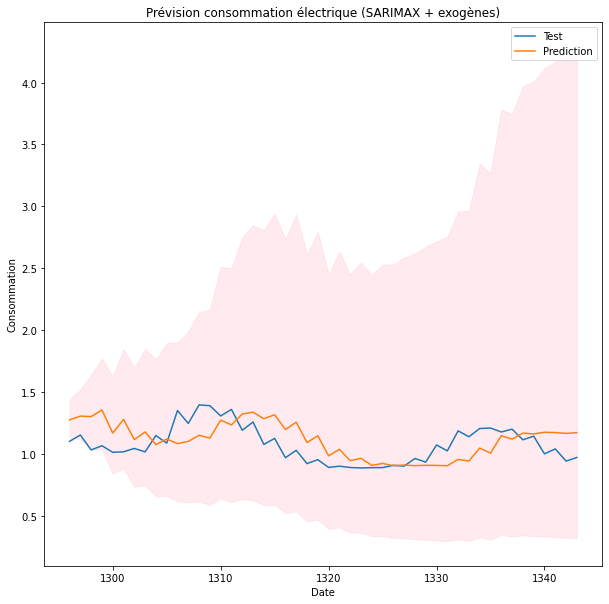

In [ ]:

plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(np.exp(test), label ='Test')
plt.plot(np.exp(prediction), label ="Prediction")

plt.fill_between(prediction.index, np.exp(conf_int.iloc[:, 0]), np.exp(conf_int.iloc[:, 1]), color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(np.exp(test), np.exp(prediction))
print(f"MAPE: {mape:.2%}")



In [ ]:
from prophet import Prophet


df_prophet = serie_log.copy()
df_prophet['ds'] = d['date'] #df_prophet.index
df_prophet['y'] = serie_log['consommation']

In [ ]:
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

# (Optionnel) Ajouter des saisonnalités personnalisées

m.fit(df_prophet)


In [ ]:
df.columns

Index(['Région', 'Code région', 'Profil', 'Plage de puissance souscrite',
       'Nb points soutirage', 'Total énergie soutirée (Wh)',
       'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
       'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
       'Courbe Moyenne n°1 + n°2 (Wh)',
       'Indice représentativité Courbe n°1 + n°2 (%)',
       'Jour max du mois (0/1)', 'Semaine max du mois (0/1)', 'AAAAMMJJHH',
       'T_moyenne', 'T_STD', 'T_min', 'T_q25', 'T_q50', 'T_q75', 'T_max',
       'T_skew', 'T_kurtosis', 'FF_moyenne', 'FF_STD', 'FF_min', 'FF_q25',
       'FF_q50', 'FF_q75', 'FF_max', 'U_moyenne', 'U_STD', 'U_min', 'U_q25',
       'U_q50', 'U_q75', 'U_max', 'date', 'year', 'month', 'month_n', 'day',
       'day_n', 'h', 'mn', 's', 'Rayonnement solaire global (W/m2)'],
      dtype='object')

In [ ]:
# les données présentent des comportements distincts dans différentes plages de valeurs et ceci pour chaque profile et chaque puissance souscrite
# Recherche de spécification linéaire de la témpérature : 
# i.e. une régression linéaire par morceaux (ou piecewise linear regression) qui ajuste plusieurs 
# segments linéaires sur différentes portions des données. 

col = 'T_moyenne'
#import pwlf 
#data = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P3: ]6-9] kVA')]
# Model de specification linéaire 
#data[col] = data[col].apply(lambda x : 1/(x + 20 ))
#data['Total énergie soutirée (Wh)'] = np.log(data['Total énergie soutirée (Wh)'])

#data = data.dropna()

model = pwlf.PiecewiseLinFit(data[col], np.exp(serie_log_np))

# Détection automatique des points de rupture
# Par exemple : 3 segments (ce paramètre peut être ajusté)
num_segments = 2
breaks = model.fit(num_segments)

# Prédiction des valeurs ajustées

T_hat = np.linspace(min(data[col]), max(data[col]), 1000)
Consommation_hat = model.predict(T_hat)




plt.figure(figsize=(10, 6))
plt.scatter(data[col], np.exp(serie_log_np) , label='Données réelles', alpha=0.6)
plt.plot(T_hat, Consommation_hat, color='red', label='Régression par morceaux', linewidth=3)
plt.vlines(breaks, ymin=min(np.exp(serie_log_np) ), ymax=max(np.exp(serie_log_np)), colors='green', linestyles='dashed',linewidth=3, label='Points de rupture')
plt.title('Régression Linéaire par Morceaux avec Détection Automatique')
plt.xlabel(col + '(°C)')
plt.ylabel('Total énergie soutirée (Wh)')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des points de rupture
print(f"Points de rupture détectés : {breaks}")


NameError: name 'serie_log_np' is not defined